# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

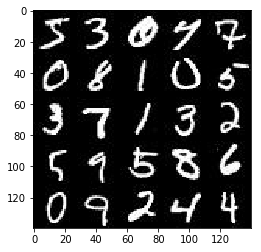

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

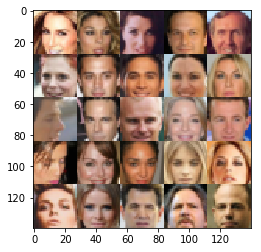

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = "input_real")
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name = "input_z")
    learning_rate = tf.placeholder(tf.float32, None)

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# I prefer to define a leaky relu function to call from outside the discriminator and the Generator
def lrelu(x, alpha):
    lrelu = tf.maximum(tf.multiply(alpha, x), x)
    return lrelu

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # As the alpha parameter is not defined in the function call I define it here and choose a value for it
    alpha = 0.2
    
    # a smaller dropout rate here than in the generator, just to avoid overfitting
    dropout = 0.45
    
    # I wanted to avoid a square distribution for the convolution Kernel, thus I define an initializer to make a normal distribution
    # init = tf.truncated_normal_initializer(mean=0.0, stddev = 0.01, seed=None, dtype=tf.float32)
    # init = tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32)
    
    with tf.variable_scope('discriminator', reuse = reuse):
        # Let's normalize the images input, it uses the 3 last axes if RGB and just the last axis if grayscale.
        # images_norm = tf.nn.l2_normalize(images, [1,2,3], epsilon=1e-6) if (len(images.get_shape().as_list()) >= 4) else tf.nn.l2_normalize(images, [1], epsilon=1e-6)
        images_norm = tf.contrib.layers.batch_norm(images, center=True, scale=True, is_training = True, scope = 'bn')
        # Layer 1
        x1 = lrelu(tf.layers.conv2d(images_norm, 128, 10, strides=1, padding='same', activation=None, 
                                    kernel_initializer= \
                                    tf.contrib.layers.xavier_initializer(uniform=False, seed=None, dtype=tf.float32)), alpha)
        
        # Layer 2
        x2 = tf.layers.conv2d(x1, 256, 10, strides = 2, padding='same', activation=None, 
                              kernel_initializer= \
                              tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        x2 = tf.layers.dropout(x2, rate = dropout)
        x2 = lrelu(tf.layers.batch_normalization(x2, training = True), alpha)
        
        # Layer 3
        x3 = tf.layers.conv2d(x2, 512, 10, strides = 2, padding='same', activation=None, 
                              kernel_initializer= \
                              tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        x3 = tf.layers.dropout(x2, rate = dropout)
        x3 = lrelu(tf.layers.batch_normalization(x3, training = True), alpha)
        
        #layer 4
        x4 = tf.layers.conv2d(x3, 1024, 10, strides = 2, padding='same', activation=None, 
                              kernel_initializer= \
                              tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        x4 = tf.layers.dropout(x2, rate = dropout)
        x4 = lrelu(tf.layers.batch_normalization(x4, training = True), alpha)
        
        # Layer 5: Logits
        x4 = tf.reshape(x3, (-1, x4.get_shape().as_list()[1] * x3.get_shape().as_list()[2] *512))
        
        logits = tf.layers.dense(x4, 1)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def gaussian_layer(input_layer, std):
    noise = tf.truncated_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
    return input_layer * (tf.ones(tf.shape(noise)) - noise )

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # let's define alpha, the reuse status, the dropout's keep rate, and the kernel's initializer
    alpha = 0.2
    reuse_bool = not is_train
    dropout = 0.5
    dropout_infer = 0.02
    # init = tf.truncated_normal_initializer(mean=0.0, stddev = 0.01, seed=None, dtype=tf.float32)
    with tf.variable_scope('generator', reuse = reuse_bool):
        
        #Let's ensure we randomize z a bit more with a shuffle
        
        z = tf.random_shuffle(z, seed=None, name=None)
        
        # First fully connected layer
        x = tf.layers.dense(z, 4 * 4 * 1024)
        x = tf.layers.dropout(x, rate = dropout) if (is_train == True) else tf.layers.dropout(x, rate = dropout_infer)
        x = tf.reshape(x, (-1, 4, 4, 1024) )
        x = gaussian_layer(x, 0.05)
        x = lrelu(tf.layers.batch_normalization(x, training = is_train), alpha)
        
        ''' I'm using the resize+conv method I found on 'http://distill.pub/2016/deconv-checkerboard/' 
        to avoid the checkerboard artifacts. It is computationally more expansive though.'''
        
        # Layer 2
        x1 = tf.image.resize_images(x, (7,7))
        x1 = tf.layers.conv2d_transpose(x1, 512, 8, strides = 1, padding='same', activation=None, 
                                        kernel_initializer=\
                                        tf.contrib.layers.xavier_initializer(uniform=False, seed=None, dtype=tf.float32))
        x1 = tf.layers.dropout(x1, rate = dropout) if (is_train == True) else tf.layers.dropout(x1, rate = dropout_infer)
        x1 = gaussian_layer(x1, 0.05)
        x1 = lrelu(tf.layers.batch_normalization(x1, training = is_train), alpha)
        
        # Layer 3
        x2 = tf.image.resize_images(x1, (14,14))
        x2 = tf.layers.conv2d_transpose(x2, 256, 8, strides = 1, padding='same', activation=None, 
                                        kernel_initializer=\
                                        tf.contrib.layers.xavier_initializer(uniform=False, seed=None, dtype=tf.float32))
        x2 = tf.layers.dropout(x2, rate = dropout) if (is_train == True) else x2
        x2 = gaussian_layer(x2, 0.01)
        x2 = lrelu(tf.layers.batch_normalization(x2, training = is_train), alpha)
        
        # Layer 4
        x3 = tf.image.resize_images(x2, (28,28))
        x3 = tf.layers.conv2d_transpose(x3, 128, 8, strides = 1, padding='same', activation=None, 
                                        kernel_initializer=\
                                        tf.contrib.layers.xavier_initializer(uniform=False, seed=None, dtype=tf.float32))
        # Dropout on the last layers was introducing ugly artifacts, so I'm not using it here
        # x3 = tf.layers.dropout(x3, rate = dropout) if (is_train == True) else x3
        x3 = gaussian_layer(x3, 0.01)
        x3 = lrelu(tf.layers.batch_normalization(x3, training = is_train), alpha)
        
        # x3 = tf.layers.dense(x3, 64, activation=None)
        
        # Layer 5: Logits
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 8, strides = 1, padding='same', activation=None, 
                                            kernel_initializer=\
                                            tf.contrib.layers.xavier_initializer(uniform=False, seed=None, dtype=tf.float32))
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
import random
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth_val= 0.09
    g_model = generator(input_z, out_channel_dim, is_train= True)
    _, d_logits_real = discriminator(input_real, reuse = False)
    d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_logits_real) * \
                                                (tf.ones_like(d_logits_real) - tf.random_uniform(tf.shape(d_logits_real),
                                                                                                 -smooth_val, smooth_val))))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_logits_fake) + \
                                                tf.random_uniform(tf.shape(d_logits_real), 
                                                                  -smooth_val, smooth_val)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Get the variables in the scope of the generator and the discriminator separately
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Get our dependencies to run the optimizer on each network
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_ops = [var for var in update_ops if var.name.startswith('discriminator')]
    g_ops = [var for var in update_ops if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(d_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        # d_train_opt = tf.train.MomentumOptimizer(learning_rate, 0.2).minimize(d_loss, var_list=d_vars)
        
    with tf.control_dependencies(g_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import time
import datetime
from tqdm import tqdm

# As in the course's example, I prefer to create my model builder outside of the train function.
class GAN:
    def __init__(self, data_shape, z_dim, learning_rate, beta1=0.5):
        
        # tf.reset_default_graph() I had to cancel the graph resetting as it was generating a tensorflow crash
        
        self.input_real, self.input_z, self.lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, data_shape[-1])
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Build the GAN
    gan = GAN(data_shape, z_dim, learning_rate, beta1)
    
    # define the steps variable
    steps = 0

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        start_time = time.time()
        for epoch_i in range(epoch_count):
            for batch_images in tqdm(get_batches(batch_size)):
                
                steps += 1 
                
                # Random uniform Noise for the Generator's Z
                batch_z = np.random.uniform(-0.99, 0.99, size=(batch_size, z_dim))
                
                # normalize inputs
                
                batch_norm = batch_images * 2 # the images in the batch are in a range between -0.5 and 0.5  
                
                '''batch_norm = [2*((image - np.mean(image))/\
                (np.max(image)-np.min(image)))-1 for image in batch_images ]'''
                
                # print(batch_norm[60])
                 
                
                # Launch optimizers
                _ = sess.run(gan.d_opt, feed_dict={gan.input_real: batch_norm, gan.input_z: batch_z, gan.lr:learning_rate})
                _ = sess.run(gan.g_opt, feed_dict={gan.input_z: batch_z, gan.lr:learning_rate})
                
                if steps % 20 == 0:
                    # Print the losses
                    train_loss_d = gan.d_loss.eval({gan.input_z: batch_z, gan.input_real: batch_norm})
                    train_loss_g = gan.g_loss.eval({gan.input_z: batch_z})

                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                         "... Elapsed Time: {}".format(str(datetime.timedelta(seconds=time.time() - start_time))))
                    
                    
                    
                # Show an example every n step
                if steps % 200 == 0:
                    
                    show_generator_output(sess, 25 , gan.input_z, data_shape[3], data_image_mode)
                    
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

19it [00:08,  2.89it/s]

Epoch 1/2 Step 20... Discriminator Loss: 3.1694... Generator Loss: 0.1681 ... Elapsed Time: 0:00:09.079350


39it [00:15,  2.91it/s]

Epoch 1/2 Step 40... Discriminator Loss: 1.0230... Generator Loss: 0.7407 ... Elapsed Time: 0:00:16.060066


59it [00:22,  2.89it/s]

Epoch 1/2 Step 60... Discriminator Loss: 0.5211... Generator Loss: 1.4318 ... Elapsed Time: 0:00:23.116481


79it [00:29,  2.91it/s]

Epoch 1/2 Step 80... Discriminator Loss: 0.2552... Generator Loss: 3.1398 ... Elapsed Time: 0:00:30.155856


99it [00:36,  2.89it/s]

Epoch 1/2 Step 100... Discriminator Loss: 0.4399... Generator Loss: 10.9234 ... Elapsed Time: 0:00:37.215778


119it [00:43,  2.90it/s]

Epoch 1/2 Step 120... Discriminator Loss: 0.6285... Generator Loss: 1.3104 ... Elapsed Time: 0:00:44.298767


139it [00:50,  2.89it/s]

Epoch 1/2 Step 140... Discriminator Loss: 0.6410... Generator Loss: 6.4855 ... Elapsed Time: 0:00:51.389278


159it [00:58,  2.86it/s]

Epoch 1/2 Step 160... Discriminator Loss: 0.0546... Generator Loss: 2.4529 ... Elapsed Time: 0:00:58.507852


179it [01:05,  2.93it/s]

Epoch 1/2 Step 180... Discriminator Loss: 0.2319... Generator Loss: 7.7318 ... Elapsed Time: 0:01:05.510118


199it [01:12,  2.91it/s]

Epoch 1/2 Step 200... Discriminator Loss: 0.3653... Generator Loss: 2.6556 ... Elapsed Time: 0:01:12.493333


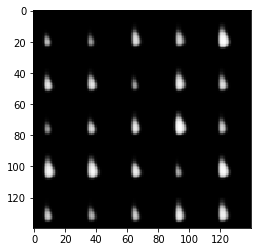

219it [01:19,  2.92it/s]

Epoch 1/2 Step 220... Discriminator Loss: 0.0489... Generator Loss: 3.9402 ... Elapsed Time: 0:01:20.276195


239it [01:26,  2.93it/s]

Epoch 1/2 Step 240... Discriminator Loss: 0.2716... Generator Loss: 2.1398 ... Elapsed Time: 0:01:27.250890


259it [01:33,  2.93it/s]

Epoch 1/2 Step 260... Discriminator Loss: 0.7711... Generator Loss: 1.0520 ... Elapsed Time: 0:01:34.245640


279it [01:40,  2.92it/s]

Epoch 1/2 Step 280... Discriminator Loss: 0.2337... Generator Loss: 1.8226 ... Elapsed Time: 0:01:41.227355


299it [01:47,  2.86it/s]

Epoch 1/2 Step 300... Discriminator Loss: 0.8844... Generator Loss: 0.6326 ... Elapsed Time: 0:01:48.269231


319it [01:54,  2.89it/s]

Epoch 1/2 Step 320... Discriminator Loss: 0.4889... Generator Loss: 1.8917 ... Elapsed Time: 0:01:55.368259


339it [02:01,  2.87it/s]

Epoch 1/2 Step 340... Discriminator Loss: 0.6362... Generator Loss: 12.8853 ... Elapsed Time: 0:02:02.458766


359it [02:09,  2.83it/s]

Epoch 1/2 Step 360... Discriminator Loss: 0.2776... Generator Loss: 3.8391 ... Elapsed Time: 0:02:09.596395


379it [02:16,  2.89it/s]

Epoch 1/2 Step 380... Discriminator Loss: 0.6757... Generator Loss: 1.4120 ... Elapsed Time: 0:02:16.678378


399it [02:23,  2.86it/s]

Epoch 1/2 Step 400... Discriminator Loss: 5.6002... Generator Loss: 7.1199 ... Elapsed Time: 0:02:23.787434


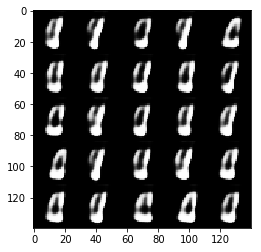

419it [02:30,  2.88it/s]

Epoch 1/2 Step 420... Discriminator Loss: 2.6572... Generator Loss: 0.2664 ... Elapsed Time: 0:02:31.389809


439it [02:38,  2.86it/s]

Epoch 1/2 Step 440... Discriminator Loss: 1.7664... Generator Loss: 2.6606 ... Elapsed Time: 0:02:38.505883


459it [02:45,  2.86it/s]

Epoch 1/2 Step 460... Discriminator Loss: 1.1347... Generator Loss: 2.2209 ... Elapsed Time: 0:02:45.652042


479it [02:52,  2.88it/s]

Epoch 1/2 Step 480... Discriminator Loss: 0.2840... Generator Loss: 4.4182 ... Elapsed Time: 0:02:52.734028


499it [02:59,  2.93it/s]

Epoch 1/2 Step 500... Discriminator Loss: 2.7244... Generator Loss: 0.3278 ... Elapsed Time: 0:02:59.736805


519it [03:06,  2.93it/s]

Epoch 1/2 Step 520... Discriminator Loss: 0.3844... Generator Loss: 2.9761 ... Elapsed Time: 0:03:06.735578


539it [03:13,  2.85it/s]

Epoch 1/2 Step 540... Discriminator Loss: 0.6972... Generator Loss: 3.8009 ... Elapsed Time: 0:03:13.860677


559it [03:20,  2.87it/s]

Epoch 1/2 Step 560... Discriminator Loss: 0.8858... Generator Loss: 1.6906 ... Elapsed Time: 0:03:20.980762


579it [03:27,  2.87it/s]

Epoch 1/2 Step 580... Discriminator Loss: 0.6780... Generator Loss: 3.6648 ... Elapsed Time: 0:03:28.099853


599it [03:34,  2.86it/s]

Epoch 1/2 Step 600... Discriminator Loss: 0.1281... Generator Loss: 7.2872 ... Elapsed Time: 0:03:35.246011


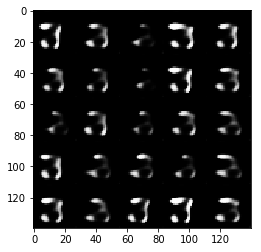

619it [03:42,  2.88it/s]

Epoch 1/2 Step 620... Discriminator Loss: 0.6507... Generator Loss: 1.5803 ... Elapsed Time: 0:03:42.846384


639it [03:49,  2.87it/s]

Epoch 1/2 Step 640... Discriminator Loss: 1.8400... Generator Loss: 0.6487 ... Elapsed Time: 0:03:49.944409


659it [03:56,  2.79it/s]

Epoch 1/2 Step 660... Discriminator Loss: 1.5529... Generator Loss: 0.3808 ... Elapsed Time: 0:03:57.148737


679it [04:03,  2.87it/s]

Epoch 1/2 Step 680... Discriminator Loss: 3.7799... Generator Loss: 0.2000 ... Elapsed Time: 0:04:04.311952


699it [04:10,  2.88it/s]

Epoch 1/2 Step 700... Discriminator Loss: 0.7784... Generator Loss: 2.3567 ... Elapsed Time: 0:04:11.400957


719it [04:18,  2.88it/s]

Epoch 1/2 Step 720... Discriminator Loss: 2.3092... Generator Loss: 4.9652 ... Elapsed Time: 0:04:18.513014


739it [04:25,  2.87it/s]

Epoch 1/2 Step 740... Discriminator Loss: 1.9115... Generator Loss: 6.5099 ... Elapsed Time: 0:04:25.626081


759it [04:32,  2.86it/s]

Epoch 1/2 Step 760... Discriminator Loss: 0.3798... Generator Loss: 2.6572 ... Elapsed Time: 0:04:32.777747


779it [04:39,  2.87it/s]

Epoch 1/2 Step 780... Discriminator Loss: 0.9266... Generator Loss: 2.3723 ... Elapsed Time: 0:04:39.915375


799it [04:46,  2.87it/s]

Epoch 1/2 Step 800... Discriminator Loss: 4.4344... Generator Loss: 0.1608 ... Elapsed Time: 0:04:47.043489


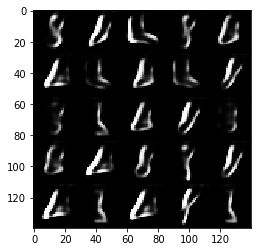

819it [04:54,  2.88it/s]

Epoch 1/2 Step 820... Discriminator Loss: 0.9822... Generator Loss: 1.6594 ... Elapsed Time: 0:04:54.644355


839it [05:01,  2.86it/s]

Epoch 1/2 Step 840... Discriminator Loss: 0.7096... Generator Loss: 4.0606 ... Elapsed Time: 0:05:01.786001


859it [05:08,  2.88it/s]

Epoch 1/2 Step 860... Discriminator Loss: 2.1482... Generator Loss: 0.5748 ... Elapsed Time: 0:05:08.907082


879it [05:15,  2.88it/s]

Epoch 1/2 Step 880... Discriminator Loss: 4.7867... Generator Loss: 0.1596 ... Elapsed Time: 0:05:16.034182


899it [05:22,  2.88it/s]

Epoch 1/2 Step 900... Discriminator Loss: 0.7987... Generator Loss: 1.3944 ... Elapsed Time: 0:05:23.161784


919it [05:29,  2.91it/s]

Epoch 1/2 Step 920... Discriminator Loss: 0.7346... Generator Loss: 2.9885 ... Elapsed Time: 0:05:30.215193


939it [05:36,  2.92it/s]

Epoch 1/2 Step 940... Discriminator Loss: 0.7533... Generator Loss: 1.3506 ... Elapsed Time: 0:05:37.248035


959it [05:43,  2.87it/s]

Epoch 1/2 Step 960... Discriminator Loss: 1.3037... Generator Loss: 1.2787 ... Elapsed Time: 0:05:44.316981


979it [05:50,  2.88it/s]

Epoch 1/2 Step 980... Discriminator Loss: 1.6201... Generator Loss: 3.5057 ... Elapsed Time: 0:05:51.431044


999it [05:58,  2.88it/s]

Epoch 1/2 Step 1000... Discriminator Loss: 1.2233... Generator Loss: 1.2403 ... Elapsed Time: 0:05:58.541111


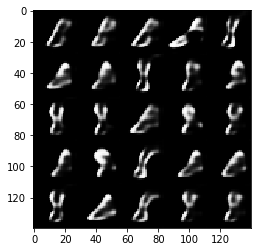

1019it [06:05,  2.86it/s]

Epoch 1/2 Step 1020... Discriminator Loss: 0.7911... Generator Loss: 1.5632 ... Elapsed Time: 0:06:06.102383


1039it [06:12,  2.87it/s]

Epoch 1/2 Step 1040... Discriminator Loss: 0.5887... Generator Loss: 1.9427 ... Elapsed Time: 0:06:13.226475


1059it [06:19,  2.87it/s]

Epoch 1/2 Step 1060... Discriminator Loss: 1.3171... Generator Loss: 1.5588 ... Elapsed Time: 0:06:20.359596


1079it [06:26,  2.86it/s]

Epoch 1/2 Step 1080... Discriminator Loss: 0.4672... Generator Loss: 2.2929 ... Elapsed Time: 0:06:27.491713


1099it [06:34,  2.86it/s]

Epoch 1/2 Step 1100... Discriminator Loss: 0.6740... Generator Loss: 2.6569 ... Elapsed Time: 0:06:34.638868


1119it [06:41,  2.86it/s]

Epoch 1/2 Step 1120... Discriminator Loss: 0.6555... Generator Loss: 1.0975 ... Elapsed Time: 0:06:41.761963


1139it [06:48,  2.88it/s]

Epoch 1/2 Step 1140... Discriminator Loss: 0.5903... Generator Loss: 1.8823 ... Elapsed Time: 0:06:48.885056


1159it [06:55,  2.87it/s]

Epoch 1/2 Step 1160... Discriminator Loss: 0.5728... Generator Loss: 1.6157 ... Elapsed Time: 0:06:56.003131


1179it [07:02,  2.90it/s]

Epoch 1/2 Step 1180... Discriminator Loss: 1.3584... Generator Loss: 1.2426 ... Elapsed Time: 0:07:03.077091


1199it [07:09,  2.85it/s]

Epoch 1/2 Step 1200... Discriminator Loss: 0.8498... Generator Loss: 1.7827 ... Elapsed Time: 0:07:10.173107


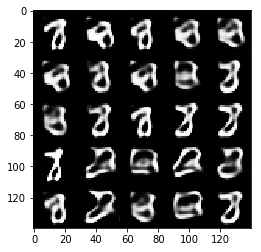

1219it [07:17,  2.86it/s]

Epoch 1/2 Step 1220... Discriminator Loss: 1.1553... Generator Loss: 0.8934 ... Elapsed Time: 0:07:17.797543


1239it [07:24,  2.86it/s]

Epoch 1/2 Step 1240... Discriminator Loss: 0.9342... Generator Loss: 2.2821 ... Elapsed Time: 0:07:24.897573


1259it [07:31,  2.87it/s]

Epoch 1/2 Step 1260... Discriminator Loss: 0.8926... Generator Loss: 1.6604 ... Elapsed Time: 0:07:32.033201


1279it [07:38,  2.87it/s]

Epoch 1/2 Step 1280... Discriminator Loss: 1.0268... Generator Loss: 1.2642 ... Elapsed Time: 0:07:39.184871


1299it [07:45,  2.85it/s]

Epoch 1/2 Step 1300... Discriminator Loss: 1.8591... Generator Loss: 0.2931 ... Elapsed Time: 0:07:46.318985


1319it [07:52,  2.85it/s]

Epoch 1/2 Step 1320... Discriminator Loss: 1.1739... Generator Loss: 1.2940 ... Elapsed Time: 0:07:53.428038


1339it [08:00,  2.86it/s]

Epoch 1/2 Step 1340... Discriminator Loss: 0.8796... Generator Loss: 1.6730 ... Elapsed Time: 0:08:00.559151


1359it [08:07,  2.86it/s]

Epoch 1/2 Step 1360... Discriminator Loss: 0.5872... Generator Loss: 1.7614 ... Elapsed Time: 0:08:07.665211


1379it [08:14,  2.85it/s]

Epoch 1/2 Step 1380... Discriminator Loss: 0.6365... Generator Loss: 2.5062 ... Elapsed Time: 0:08:14.868587


1399it [08:21,  2.92it/s]

Epoch 1/2 Step 1400... Discriminator Loss: 0.6887... Generator Loss: 1.4705 ... Elapsed Time: 0:08:21.905953


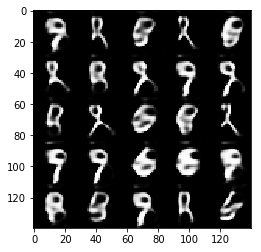

1419it [08:29,  2.87it/s]

Epoch 1/2 Step 1420... Discriminator Loss: 1.2963... Generator Loss: 1.6578 ... Elapsed Time: 0:08:29.599572


1439it [08:36,  2.87it/s]

Epoch 1/2 Step 1440... Discriminator Loss: 0.7544... Generator Loss: 1.7638 ... Elapsed Time: 0:08:36.732693


1459it [08:43,  2.85it/s]

Epoch 1/2 Step 1460... Discriminator Loss: 0.9356... Generator Loss: 1.5451 ... Elapsed Time: 0:08:43.891881


1479it [08:50,  2.89it/s]

Epoch 1/2 Step 1480... Discriminator Loss: 0.8978... Generator Loss: 1.3849 ... Elapsed Time: 0:08:50.984382


1499it [08:57,  2.89it/s]

Epoch 1/2 Step 1500... Discriminator Loss: 0.7277... Generator Loss: 1.6260 ... Elapsed Time: 0:08:58.095939


1519it [09:04,  2.92it/s]

Epoch 1/2 Step 1520... Discriminator Loss: 1.3522... Generator Loss: 3.8496 ... Elapsed Time: 0:09:05.128794


1539it [09:11,  2.84it/s]

Epoch 1/2 Step 1540... Discriminator Loss: 0.5995... Generator Loss: 2.5934 ... Elapsed Time: 0:09:12.258404


1559it [09:18,  2.89it/s]

Epoch 1/2 Step 1560... Discriminator Loss: 0.8070... Generator Loss: 2.2720 ... Elapsed Time: 0:09:19.343896


1579it [09:25,  2.89it/s]

Epoch 1/2 Step 1580... Discriminator Loss: 1.1633... Generator Loss: 1.1763 ... Elapsed Time: 0:09:26.445934


1599it [09:33,  2.86it/s]

Epoch 1/2 Step 1600... Discriminator Loss: 2.0659... Generator Loss: 0.4733 ... Elapsed Time: 0:09:33.569025


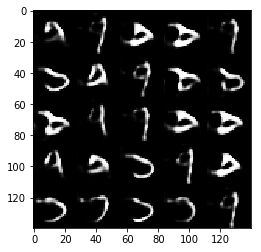

1619it [09:40,  2.84it/s]

Epoch 1/2 Step 1620... Discriminator Loss: 0.9924... Generator Loss: 1.1427 ... Elapsed Time: 0:09:41.201485


1639it [09:47,  2.87it/s]

Epoch 1/2 Step 1640... Discriminator Loss: 0.5504... Generator Loss: 1.9394 ... Elapsed Time: 0:09:48.352654


1659it [09:54,  2.89it/s]

Epoch 1/2 Step 1660... Discriminator Loss: 0.5107... Generator Loss: 2.4004 ... Elapsed Time: 0:09:55.465723


1679it [10:02,  2.85it/s]

Epoch 1/2 Step 1680... Discriminator Loss: 1.7970... Generator Loss: 3.6532 ... Elapsed Time: 0:10:02.632938


1699it [10:09,  2.86it/s]

Epoch 1/2 Step 1700... Discriminator Loss: 0.3210... Generator Loss: 1.5188 ... Elapsed Time: 0:10:09.753018


1719it [10:16,  2.84it/s]

Epoch 1/2 Step 1720... Discriminator Loss: 1.0326... Generator Loss: 2.5901 ... Elapsed Time: 0:10:16.854052


1739it [10:23,  2.86it/s]

Epoch 1/2 Step 1740... Discriminator Loss: 0.6905... Generator Loss: 2.1617 ... Elapsed Time: 0:10:23.981150


1759it [10:30,  2.86it/s]

Epoch 1/2 Step 1760... Discriminator Loss: 1.0467... Generator Loss: 2.1947 ... Elapsed Time: 0:10:31.090206


1779it [10:37,  2.88it/s]

Epoch 1/2 Step 1780... Discriminator Loss: 0.8436... Generator Loss: 1.6103 ... Elapsed Time: 0:10:38.189233


1799it [10:44,  2.86it/s]

Epoch 1/2 Step 1800... Discriminator Loss: 1.5925... Generator Loss: 2.8578 ... Elapsed Time: 0:10:45.300293


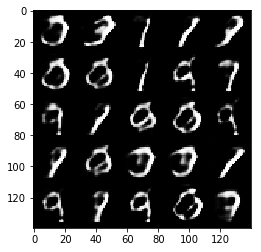

1819it [10:52,  2.85it/s]

Epoch 1/2 Step 1820... Discriminator Loss: 1.6470... Generator Loss: 0.4016 ... Elapsed Time: 0:10:52.942784


1839it [10:59,  2.87it/s]

Epoch 1/2 Step 1840... Discriminator Loss: 0.6145... Generator Loss: 2.1606 ... Elapsed Time: 0:11:00.061867


1859it [11:06,  2.92it/s]

Epoch 1/2 Step 1860... Discriminator Loss: 1.8301... Generator Loss: 4.4544 ... Elapsed Time: 0:11:07.090708


1875it [11:12,  2.88it/s]
4it [00:01,  2.93it/s]

Epoch 2/2 Step 1880... Discriminator Loss: 0.9002... Generator Loss: 1.4271 ... Elapsed Time: 0:11:14.120550


24it [00:08,  2.95it/s]

Epoch 2/2 Step 1900... Discriminator Loss: 0.7489... Generator Loss: 1.6021 ... Elapsed Time: 0:11:21.068182


44it [00:15,  2.93it/s]

Epoch 2/2 Step 1920... Discriminator Loss: 0.4544... Generator Loss: 3.2076 ... Elapsed Time: 0:11:28.035861


64it [00:22,  2.94it/s]

Epoch 2/2 Step 1940... Discriminator Loss: 0.7018... Generator Loss: 1.3129 ... Elapsed Time: 0:11:35.009556


84it [00:29,  2.93it/s]

Epoch 2/2 Step 1960... Discriminator Loss: 0.6345... Generator Loss: 3.7409 ... Elapsed Time: 0:11:41.982744


104it [00:36,  2.94it/s]

Epoch 2/2 Step 1980... Discriminator Loss: 0.4141... Generator Loss: 1.7079 ... Elapsed Time: 0:11:48.937886


124it [00:43,  2.94it/s]

Epoch 2/2 Step 2000... Discriminator Loss: 0.7661... Generator Loss: 3.0061 ... Elapsed Time: 0:11:55.890521


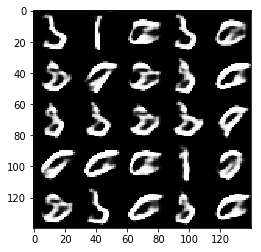

144it [00:50,  2.95it/s]

Epoch 2/2 Step 2020... Discriminator Loss: 0.7297... Generator Loss: 2.2717 ... Elapsed Time: 0:12:03.339491


164it [00:57,  2.94it/s]

Epoch 2/2 Step 2040... Discriminator Loss: 0.8047... Generator Loss: 1.8301 ... Elapsed Time: 0:12:10.308169


184it [01:04,  2.91it/s]

Epoch 2/2 Step 2060... Discriminator Loss: 0.6382... Generator Loss: 2.0248 ... Elapsed Time: 0:12:17.286869


204it [01:11,  2.94it/s]

Epoch 2/2 Step 2080... Discriminator Loss: 0.5988... Generator Loss: 1.1682 ... Elapsed Time: 0:12:24.238497


224it [01:18,  2.94it/s]

Epoch 2/2 Step 2100... Discriminator Loss: 0.3843... Generator Loss: 1.9257 ... Elapsed Time: 0:12:31.183117


244it [01:25,  2.94it/s]

Epoch 2/2 Step 2120... Discriminator Loss: 1.1192... Generator Loss: 0.6606 ... Elapsed Time: 0:12:38.121719


264it [01:32,  2.93it/s]

Epoch 2/2 Step 2140... Discriminator Loss: 0.9332... Generator Loss: 0.9111 ... Elapsed Time: 0:12:45.074356


284it [01:39,  2.93it/s]

Epoch 2/2 Step 2160... Discriminator Loss: 1.1395... Generator Loss: 2.1071 ... Elapsed Time: 0:12:52.034512


304it [01:46,  2.92it/s]

Epoch 2/2 Step 2180... Discriminator Loss: 0.9097... Generator Loss: 1.4838 ... Elapsed Time: 0:12:59.007701


324it [01:53,  2.93it/s]

Epoch 2/2 Step 2200... Discriminator Loss: 0.7398... Generator Loss: 1.7362 ... Elapsed Time: 0:13:05.953316


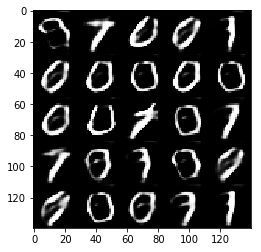

344it [02:00,  2.93it/s]

Epoch 2/2 Step 2220... Discriminator Loss: 0.7147... Generator Loss: 1.3157 ... Elapsed Time: 0:13:13.424356


364it [02:07,  2.92it/s]

Epoch 2/2 Step 2240... Discriminator Loss: 0.8422... Generator Loss: 1.3610 ... Elapsed Time: 0:13:20.375992


384it [02:14,  2.94it/s]

Epoch 2/2 Step 2260... Discriminator Loss: 0.6265... Generator Loss: 3.3870 ... Elapsed Time: 0:13:27.321612


404it [02:21,  2.96it/s]

Epoch 2/2 Step 2280... Discriminator Loss: 0.8343... Generator Loss: 2.9348 ... Elapsed Time: 0:13:34.265723


424it [02:28,  2.92it/s]

Epoch 2/2 Step 2300... Discriminator Loss: 0.7600... Generator Loss: 2.0785 ... Elapsed Time: 0:13:41.228888


444it [02:35,  2.91it/s]

Epoch 2/2 Step 2320... Discriminator Loss: 1.0987... Generator Loss: 2.0262 ... Elapsed Time: 0:13:48.184532


464it [02:42,  2.95it/s]

Epoch 2/2 Step 2340... Discriminator Loss: 1.1405... Generator Loss: 2.8611 ... Elapsed Time: 0:13:55.139179


484it [02:49,  2.92it/s]

Epoch 2/2 Step 2360... Discriminator Loss: 0.5021... Generator Loss: 2.3209 ... Elapsed Time: 0:14:02.110867


504it [02:56,  2.95it/s]

Epoch 2/2 Step 2380... Discriminator Loss: 2.9210... Generator Loss: 0.2327 ... Elapsed Time: 0:14:09.062004


524it [03:03,  2.94it/s]

Epoch 2/2 Step 2400... Discriminator Loss: 0.7453... Generator Loss: 2.1900 ... Elapsed Time: 0:14:16.009124


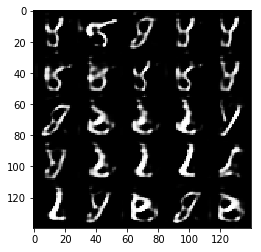

544it [03:10,  2.94it/s]

Epoch 2/2 Step 2420... Discriminator Loss: 0.8238... Generator Loss: 1.5499 ... Elapsed Time: 0:14:23.472122


564it [03:17,  2.92it/s]

Epoch 2/2 Step 2440... Discriminator Loss: 0.6760... Generator Loss: 2.5332 ... Elapsed Time: 0:14:30.417735


584it [03:24,  2.94it/s]

Epoch 2/2 Step 2460... Discriminator Loss: 0.6568... Generator Loss: 1.5383 ... Elapsed Time: 0:14:37.392431


604it [03:31,  2.95it/s]

Epoch 2/2 Step 2480... Discriminator Loss: 0.5197... Generator Loss: 1.8722 ... Elapsed Time: 0:14:44.325015


624it [03:38,  2.93it/s]

Epoch 2/2 Step 2500... Discriminator Loss: 0.3731... Generator Loss: 3.8980 ... Elapsed Time: 0:14:51.290684


644it [03:45,  2.93it/s]

Epoch 2/2 Step 2520... Discriminator Loss: 3.0669... Generator Loss: 0.2114 ... Elapsed Time: 0:14:58.255359


664it [03:52,  2.95it/s]

Epoch 2/2 Step 2540... Discriminator Loss: 2.6865... Generator Loss: 0.2209 ... Elapsed Time: 0:15:05.192950


684it [03:59,  2.92it/s]

Epoch 2/2 Step 2560... Discriminator Loss: 1.0058... Generator Loss: 1.3723 ... Elapsed Time: 0:15:12.145582


704it [04:06,  2.97it/s]

Epoch 2/2 Step 2580... Discriminator Loss: 0.7390... Generator Loss: 0.8693 ... Elapsed Time: 0:15:19.063123


724it [04:13,  2.94it/s]

Epoch 2/2 Step 2600... Discriminator Loss: 0.5417... Generator Loss: 2.4455 ... Elapsed Time: 0:15:26.016261


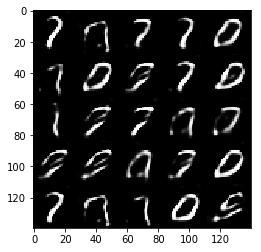

744it [04:20,  2.93it/s]

Epoch 2/2 Step 2620... Discriminator Loss: 1.2507... Generator Loss: 0.3556 ... Elapsed Time: 0:15:33.494804


764it [04:27,  2.94it/s]

Epoch 2/2 Step 2640... Discriminator Loss: 1.5206... Generator Loss: 2.8047 ... Elapsed Time: 0:15:40.458472


784it [04:34,  2.95it/s]

Epoch 2/2 Step 2660... Discriminator Loss: 0.7557... Generator Loss: 1.4626 ... Elapsed Time: 0:15:47.405097


804it [04:41,  2.94it/s]

Epoch 2/2 Step 2680... Discriminator Loss: 0.4286... Generator Loss: 2.1767 ... Elapsed Time: 0:15:54.353218


824it [04:48,  2.92it/s]

Epoch 2/2 Step 2700... Discriminator Loss: 0.7653... Generator Loss: 1.4508 ... Elapsed Time: 0:16:01.318393


844it [04:55,  2.92it/s]

Epoch 2/2 Step 2720... Discriminator Loss: 0.6572... Generator Loss: 1.8133 ... Elapsed Time: 0:16:08.276045


864it [05:02,  2.95it/s]

Epoch 2/2 Step 2740... Discriminator Loss: 0.5719... Generator Loss: 2.7141 ... Elapsed Time: 0:16:15.224672


884it [05:09,  2.93it/s]

Epoch 2/2 Step 2760... Discriminator Loss: 0.7095... Generator Loss: 3.0088 ... Elapsed Time: 0:16:22.199373


904it [05:16,  2.94it/s]

Epoch 2/2 Step 2780... Discriminator Loss: 1.3217... Generator Loss: 0.7502 ... Elapsed Time: 0:16:29.139984


924it [05:23,  2.94it/s]

Epoch 2/2 Step 2800... Discriminator Loss: 2.3368... Generator Loss: 0.2754 ... Elapsed Time: 0:16:36.105656


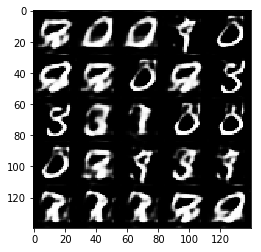

944it [05:30,  2.93it/s]

Epoch 2/2 Step 2820... Discriminator Loss: 1.0791... Generator Loss: 1.1668 ... Elapsed Time: 0:16:43.702014


964it [05:37,  2.93it/s]

Epoch 2/2 Step 2840... Discriminator Loss: 1.0432... Generator Loss: 1.4072 ... Elapsed Time: 0:16:50.665682


984it [05:44,  2.95it/s]

Epoch 2/2 Step 2860... Discriminator Loss: 0.6111... Generator Loss: 1.3796 ... Elapsed Time: 0:16:57.619323


1004it [05:51,  2.94it/s]

Epoch 2/2 Step 2880... Discriminator Loss: 0.6703... Generator Loss: 2.5425 ... Elapsed Time: 0:17:04.600028


1024it [05:58,  2.93it/s]

Epoch 2/2 Step 2900... Discriminator Loss: 1.1612... Generator Loss: 1.9164 ... Elapsed Time: 0:17:11.565699


1044it [06:05,  2.94it/s]

Epoch 2/2 Step 2920... Discriminator Loss: 0.3964... Generator Loss: 2.7803 ... Elapsed Time: 0:17:18.526354


1064it [06:12,  2.93it/s]

Epoch 2/2 Step 2940... Discriminator Loss: 0.5129... Generator Loss: 1.0145 ... Elapsed Time: 0:17:25.482996


1084it [06:19,  2.92it/s]

Epoch 2/2 Step 2960... Discriminator Loss: 1.0057... Generator Loss: 0.8620 ... Elapsed Time: 0:17:32.440647


1104it [06:26,  2.92it/s]

Epoch 2/2 Step 2980... Discriminator Loss: 0.5869... Generator Loss: 2.4588 ... Elapsed Time: 0:17:39.412334


1124it [06:33,  2.94it/s]

Epoch 2/2 Step 3000... Discriminator Loss: 1.4263... Generator Loss: 0.6952 ... Elapsed Time: 0:17:46.383017


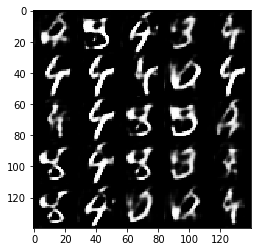

1144it [06:41,  2.93it/s]

Epoch 2/2 Step 3020... Discriminator Loss: 0.9100... Generator Loss: 1.1443 ... Elapsed Time: 0:17:53.871087


1164it [06:48,  2.89it/s]

Epoch 2/2 Step 3040... Discriminator Loss: 0.7279... Generator Loss: 4.1337 ... Elapsed Time: 0:18:00.871862


1184it [06:55,  2.90it/s]

Epoch 2/2 Step 3060... Discriminator Loss: 0.5041... Generator Loss: 2.7205 ... Elapsed Time: 0:18:07.930313


1204it [07:02,  2.89it/s]

Epoch 2/2 Step 3080... Discriminator Loss: 0.9982... Generator Loss: 0.4299 ... Elapsed Time: 0:18:14.948635


1224it [07:09,  2.93it/s]

Epoch 2/2 Step 3100... Discriminator Loss: 1.6185... Generator Loss: 3.8258 ... Elapsed Time: 0:18:21.912300


1244it [07:16,  2.91it/s]

Epoch 2/2 Step 3120... Discriminator Loss: 1.1965... Generator Loss: 0.6119 ... Elapsed Time: 0:18:28.889996


1264it [07:23,  2.95it/s]

Epoch 2/2 Step 3140... Discriminator Loss: 1.1530... Generator Loss: 0.6195 ... Elapsed Time: 0:18:35.823577


1284it [07:30,  2.92it/s]

Epoch 2/2 Step 3160... Discriminator Loss: 1.4693... Generator Loss: 2.2356 ... Elapsed Time: 0:18:42.788244


1304it [07:36,  2.94it/s]

Epoch 2/2 Step 3180... Discriminator Loss: 1.0364... Generator Loss: 0.7099 ... Elapsed Time: 0:18:49.752414


1324it [07:43,  2.95it/s]

Epoch 2/2 Step 3200... Discriminator Loss: 1.4576... Generator Loss: 0.8359 ... Elapsed Time: 0:18:56.717586


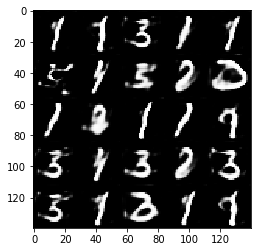

1344it [07:51,  2.93it/s]

Epoch 2/2 Step 3220... Discriminator Loss: 0.8158... Generator Loss: 2.4098 ... Elapsed Time: 0:19:04.199640


1364it [07:58,  2.93it/s]

Epoch 2/2 Step 3240... Discriminator Loss: 1.6714... Generator Loss: 0.3964 ... Elapsed Time: 0:19:11.147263


1384it [08:05,  2.94it/s]

Epoch 2/2 Step 3260... Discriminator Loss: 0.9472... Generator Loss: 0.9193 ... Elapsed Time: 0:19:18.109932


1404it [08:12,  2.92it/s]

Epoch 2/2 Step 3280... Discriminator Loss: 0.7592... Generator Loss: 1.1006 ... Elapsed Time: 0:19:25.101677


1424it [08:19,  2.94it/s]

Epoch 2/2 Step 3300... Discriminator Loss: 0.4324... Generator Loss: 1.8889 ... Elapsed Time: 0:19:32.059324


1444it [08:26,  2.92it/s]

Epoch 2/2 Step 3320... Discriminator Loss: 0.8542... Generator Loss: 3.5314 ... Elapsed Time: 0:19:39.026001


1464it [08:33,  2.94it/s]

Epoch 2/2 Step 3340... Discriminator Loss: 0.6770... Generator Loss: 2.9145 ... Elapsed Time: 0:19:45.984661


1484it [08:40,  2.92it/s]

Epoch 2/2 Step 3360... Discriminator Loss: 1.2290... Generator Loss: 0.7012 ... Elapsed Time: 0:19:52.941305


1504it [08:47,  2.94it/s]

Epoch 2/2 Step 3380... Discriminator Loss: 0.9711... Generator Loss: 1.3454 ... Elapsed Time: 0:19:59.895945


1524it [08:54,  2.94it/s]

Epoch 2/2 Step 3400... Discriminator Loss: 1.3452... Generator Loss: 2.8037 ... Elapsed Time: 0:20:06.849084


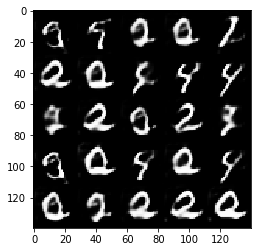

1544it [09:01,  2.91it/s]

Epoch 2/2 Step 3420... Discriminator Loss: 1.8341... Generator Loss: 2.0827 ... Elapsed Time: 0:20:14.376763


1564it [09:08,  2.93it/s]

Epoch 2/2 Step 3440... Discriminator Loss: 1.1152... Generator Loss: 1.1191 ... Elapsed Time: 0:20:21.360482


1584it [09:15,  2.92it/s]

Epoch 2/2 Step 3460... Discriminator Loss: 1.2751... Generator Loss: 0.8914 ... Elapsed Time: 0:20:28.333672


1604it [09:22,  2.94it/s]

Epoch 2/2 Step 3480... Discriminator Loss: 0.6435... Generator Loss: 2.2611 ... Elapsed Time: 0:20:35.292320


1624it [09:29,  2.94it/s]

Epoch 2/2 Step 3500... Discriminator Loss: 1.3951... Generator Loss: 0.6415 ... Elapsed Time: 0:20:42.243454


1644it [09:36,  2.94it/s]

Epoch 2/2 Step 3520... Discriminator Loss: 0.6853... Generator Loss: 1.7495 ... Elapsed Time: 0:20:49.199095


1664it [09:43,  2.94it/s]

Epoch 2/2 Step 3540... Discriminator Loss: 0.6255... Generator Loss: 1.5824 ... Elapsed Time: 0:20:56.145709


1684it [09:50,  2.93it/s]

Epoch 2/2 Step 3560... Discriminator Loss: 0.8317... Generator Loss: 2.3312 ... Elapsed Time: 0:21:03.133941


1704it [09:57,  2.93it/s]

Epoch 2/2 Step 3580... Discriminator Loss: 0.5795... Generator Loss: 1.8626 ... Elapsed Time: 0:21:10.111140


1724it [10:04,  2.93it/s]

Epoch 2/2 Step 3600... Discriminator Loss: 2.3933... Generator Loss: 0.7491 ... Elapsed Time: 0:21:17.063776


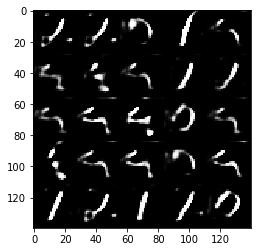

1744it [10:11,  2.94it/s]

Epoch 2/2 Step 3620... Discriminator Loss: 1.0647... Generator Loss: 1.3627 ... Elapsed Time: 0:21:24.536799


1764it [10:18,  2.92it/s]

Epoch 2/2 Step 3640... Discriminator Loss: 0.9482... Generator Loss: 1.8222 ... Elapsed Time: 0:21:31.499471


1784it [10:25,  2.95it/s]

Epoch 2/2 Step 3660... Discriminator Loss: 1.3584... Generator Loss: 0.6147 ... Elapsed Time: 0:21:38.467148


1804it [10:32,  2.93it/s]

Epoch 2/2 Step 3680... Discriminator Loss: 1.5190... Generator Loss: 0.6863 ... Elapsed Time: 0:21:45.448862


1824it [10:39,  2.94it/s]

Epoch 2/2 Step 3700... Discriminator Loss: 0.7316... Generator Loss: 1.8342 ... Elapsed Time: 0:21:52.376427


1844it [10:46,  2.94it/s]

Epoch 2/2 Step 3720... Discriminator Loss: 0.3883... Generator Loss: 1.5785 ... Elapsed Time: 0:21:59.331074


1864it [10:53,  2.93it/s]

Epoch 2/2 Step 3740... Discriminator Loss: 0.8394... Generator Loss: 1.5932 ... Elapsed Time: 0:22:06.295745


1875it [10:57,  2.91it/s]


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2 Step 20... Discriminator Loss: 0.5134... Generator Loss: 1.1006 ... Elapsed Time: 0:00:08.020331
Epoch 1/2 Step 40... Discriminator Loss: 0.5016... Generator Loss: 3.3935 ... Elapsed Time: 0:00:15.695744
Epoch 1/2 Step 60... Discriminator Loss: 0.5739... Generator Loss: 1.0012 ... Elapsed Time: 0:00:23.394219
Epoch 1/2 Step 80... Discriminator Loss: 0.4752... Generator Loss: 1.3831 ... Elapsed Time: 0:00:31.148843
Epoch 1/2 Step 100... Discriminator Loss: 0.9800... Generator Loss: 0.4912 ... Elapsed Time: 0:00:38.916501
Epoch 1/2 Step 120... Discriminator Loss: 0.5602... Generator Loss: 5.7275 ... Elapsed Time: 0:00:46.628011
Epoch 1/2 Step 140... Discriminator Loss: 2.2645... Generator Loss: 0.1849 ... Elapsed Time: 0:00:54.361579
Epoch 1/2 Step 160... Discriminator Loss: 0.6203... Generator Loss: 3.8390 ... Elapsed Time: 0:01:02.100160
Epoch 1/2 Step 180... Discriminator Loss: 0.6822... Generator Loss: 0.7985 ... Elapsed Time: 0:01:09.831722
Epoch 1/2 Step 200... Discrimina

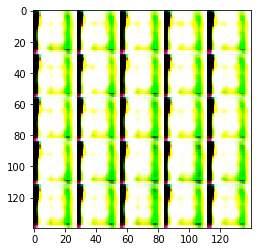

Epoch 1/2 Step 220... Discriminator Loss: 0.5200... Generator Loss: 1.6541 ... Elapsed Time: 0:01:25.678869
Epoch 1/2 Step 240... Discriminator Loss: 1.6100... Generator Loss: 0.2911 ... Elapsed Time: 0:01:33.433493
Epoch 1/2 Step 260... Discriminator Loss: 0.4927... Generator Loss: 1.3053 ... Elapsed Time: 0:01:41.155029
Epoch 1/2 Step 280... Discriminator Loss: 0.9600... Generator Loss: 0.6899 ... Elapsed Time: 0:01:48.869547
Epoch 1/2 Step 300... Discriminator Loss: 1.1727... Generator Loss: 0.9069 ... Elapsed Time: 0:01:56.503851
Epoch 1/2 Step 320... Discriminator Loss: 1.0214... Generator Loss: 0.7245 ... Elapsed Time: 0:02:04.234411
Epoch 1/2 Step 340... Discriminator Loss: 0.6178... Generator Loss: 1.7194 ... Elapsed Time: 0:02:11.977003
Epoch 1/2 Step 360... Discriminator Loss: 0.6612... Generator Loss: 1.2877 ... Elapsed Time: 0:02:19.705137
Epoch 1/2 Step 380... Discriminator Loss: 2.3164... Generator Loss: 0.2126 ... Elapsed Time: 0:02:27.395590
Epoch 1/2 Step 400... Discri

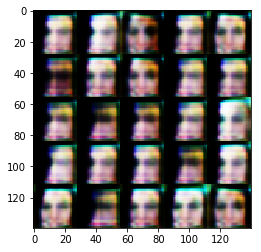

Epoch 1/2 Step 420... Discriminator Loss: 1.0940... Generator Loss: 0.6318 ... Elapsed Time: 0:02:43.348017
Epoch 1/2 Step 440... Discriminator Loss: 1.0202... Generator Loss: 1.0581 ... Elapsed Time: 0:02:51.226896
Epoch 1/2 Step 460... Discriminator Loss: 0.8098... Generator Loss: 1.0835 ... Elapsed Time: 0:02:59.136337
Epoch 1/2 Step 480... Discriminator Loss: 2.1243... Generator Loss: 0.4014 ... Elapsed Time: 0:03:06.915026
Epoch 1/2 Step 500... Discriminator Loss: 0.7436... Generator Loss: 1.1833 ... Elapsed Time: 0:03:14.566372
Epoch 1/2 Step 520... Discriminator Loss: 0.4902... Generator Loss: 1.3140 ... Elapsed Time: 0:03:22.266854
Epoch 1/2 Step 540... Discriminator Loss: 0.5087... Generator Loss: 2.3800 ... Elapsed Time: 0:03:29.905167
Epoch 1/2 Step 560... Discriminator Loss: 0.8058... Generator Loss: 1.7873 ... Elapsed Time: 0:03:37.646756
Epoch 1/2 Step 580... Discriminator Loss: 0.9441... Generator Loss: 1.4178 ... Elapsed Time: 0:03:45.524182
Epoch 1/2 Step 600... Discri

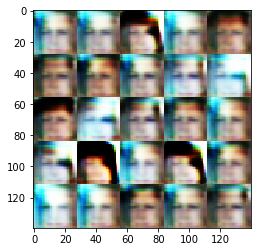

Epoch 1/2 Step 620... Discriminator Loss: 1.1931... Generator Loss: 0.6923 ... Elapsed Time: 0:04:01.640612
Epoch 1/2 Step 640... Discriminator Loss: 1.1379... Generator Loss: 0.7560 ... Elapsed Time: 0:04:09.384206
Epoch 1/2 Step 660... Discriminator Loss: 1.0616... Generator Loss: 1.0555 ... Elapsed Time: 0:04:17.093714
Epoch 1/2 Step 680... Discriminator Loss: 0.5847... Generator Loss: 2.1603 ... Elapsed Time: 0:04:24.772132
Epoch 1/2 Step 700... Discriminator Loss: 1.3219... Generator Loss: 1.0909 ... Elapsed Time: 0:04:32.498681
Epoch 1/2 Step 720... Discriminator Loss: 0.6562... Generator Loss: 1.9037 ... Elapsed Time: 0:04:40.301433
Epoch 1/2 Step 740... Discriminator Loss: 1.2759... Generator Loss: 0.6981 ... Elapsed Time: 0:04:48.023972
Epoch 1/2 Step 760... Discriminator Loss: 1.1261... Generator Loss: 0.4867 ... Elapsed Time: 0:04:55.769572
Epoch 1/2 Step 780... Discriminator Loss: 0.7181... Generator Loss: 1.3651 ... Elapsed Time: 0:05:03.498127
Epoch 1/2 Step 800... Discri

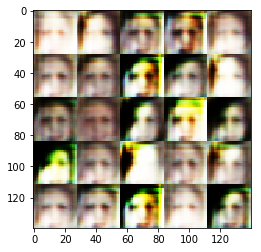

Epoch 1/2 Step 820... Discriminator Loss: 0.7127... Generator Loss: 1.2794 ... Elapsed Time: 0:05:19.415048
Epoch 1/2 Step 840... Discriminator Loss: 0.5904... Generator Loss: 2.0826 ... Elapsed Time: 0:05:27.149618
Epoch 1/2 Step 860... Discriminator Loss: 0.6109... Generator Loss: 1.6120 ... Elapsed Time: 0:05:34.961394
Epoch 1/2 Step 880... Discriminator Loss: 0.8430... Generator Loss: 1.0430 ... Elapsed Time: 0:05:42.683933
Epoch 1/2 Step 900... Discriminator Loss: 1.1736... Generator Loss: 0.6746 ... Elapsed Time: 0:05:50.425523
Epoch 1/2 Step 920... Discriminator Loss: 1.6442... Generator Loss: 0.4360 ... Elapsed Time: 0:05:58.213234
Epoch 1/2 Step 940... Discriminator Loss: 1.7672... Generator Loss: 0.3391 ... Elapsed Time: 0:06:05.994931
Epoch 1/2 Step 960... Discriminator Loss: 1.3224... Generator Loss: 0.4579 ... Elapsed Time: 0:06:13.722483
Epoch 1/2 Step 980... Discriminator Loss: 0.7589... Generator Loss: 1.5420 ... Elapsed Time: 0:06:21.452040
Epoch 1/2 Step 1000... Discr

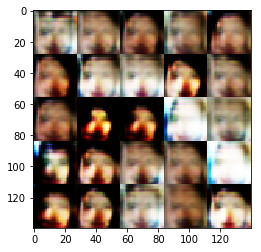

Epoch 1/2 Step 1020... Discriminator Loss: 0.4517... Generator Loss: 1.7099 ... Elapsed Time: 0:06:37.441565
Epoch 1/2 Step 1040... Discriminator Loss: 1.1246... Generator Loss: 0.7935 ... Elapsed Time: 0:06:45.223262
Epoch 1/2 Step 1060... Discriminator Loss: 0.7916... Generator Loss: 2.4962 ... Elapsed Time: 0:06:53.031097
Epoch 1/2 Step 1080... Discriminator Loss: 0.7349... Generator Loss: 0.8196 ... Elapsed Time: 0:07:00.897227
Epoch 1/2 Step 1100... Discriminator Loss: 1.9663... Generator Loss: 0.3699 ... Elapsed Time: 0:07:08.614757
Epoch 1/2 Step 1120... Discriminator Loss: 0.7314... Generator Loss: 1.6920 ... Elapsed Time: 0:07:16.296186
Epoch 1/2 Step 1140... Discriminator Loss: 1.0018... Generator Loss: 0.7384 ... Elapsed Time: 0:07:24.082001
Epoch 1/2 Step 1160... Discriminator Loss: 0.7704... Generator Loss: 2.5851 ... Elapsed Time: 0:07:31.896288
Epoch 1/2 Step 1180... Discriminator Loss: 1.2690... Generator Loss: 0.4550 ... Elapsed Time: 0:07:39.622837
Epoch 1/2 Step 1200

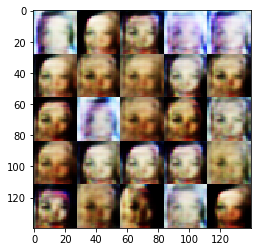

Epoch 1/2 Step 1220... Discriminator Loss: 0.7984... Generator Loss: 1.4838 ... Elapsed Time: 0:07:55.627403
Epoch 1/2 Step 1240... Discriminator Loss: 1.0782... Generator Loss: 0.7973 ... Elapsed Time: 0:08:03.384032
Epoch 1/2 Step 1260... Discriminator Loss: 1.1570... Generator Loss: 0.5965 ... Elapsed Time: 0:08:11.135655
Epoch 1/2 Step 1280... Discriminator Loss: 1.1048... Generator Loss: 0.6449 ... Elapsed Time: 0:08:18.838133
Epoch 1/2 Step 1300... Discriminator Loss: 0.7396... Generator Loss: 1.2175 ... Elapsed Time: 0:08:26.513547
Epoch 1/2 Step 1320... Discriminator Loss: 1.4724... Generator Loss: 0.3897 ... Elapsed Time: 0:08:34.240096
Epoch 1/2 Step 1340... Discriminator Loss: 1.2252... Generator Loss: 0.7163 ... Elapsed Time: 0:08:41.948597
Epoch 1/2 Step 1360... Discriminator Loss: 0.7028... Generator Loss: 1.3223 ... Elapsed Time: 0:08:49.673141
Epoch 1/2 Step 1380... Discriminator Loss: 0.6249... Generator Loss: 1.1079 ... Elapsed Time: 0:08:57.439797
Epoch 1/2 Step 1400

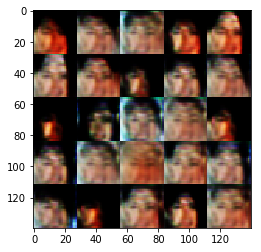

Epoch 1/2 Step 1420... Discriminator Loss: 0.6440... Generator Loss: 1.5308 ... Elapsed Time: 0:09:13.607460
Epoch 1/2 Step 1440... Discriminator Loss: 1.0194... Generator Loss: 0.5360 ... Elapsed Time: 0:09:21.317433
Epoch 1/2 Step 1460... Discriminator Loss: 0.6059... Generator Loss: 1.4727 ... Elapsed Time: 0:09:29.122190
Epoch 1/2 Step 1480... Discriminator Loss: 0.9303... Generator Loss: 0.7834 ... Elapsed Time: 0:09:36.842723
Epoch 1/2 Step 1500... Discriminator Loss: 0.6587... Generator Loss: 2.1289 ... Elapsed Time: 0:09:44.468003
Epoch 1/2 Step 1520... Discriminator Loss: 1.3487... Generator Loss: 0.6172 ... Elapsed Time: 0:09:52.104312
Epoch 1/2 Step 1540... Discriminator Loss: 1.8721... Generator Loss: 0.3183 ... Elapsed Time: 0:09:59.766691
Epoch 1/2 Step 1560... Discriminator Loss: 0.7469... Generator Loss: 0.9655 ... Elapsed Time: 0:10:07.574456
Epoch 1/2 Step 1580... Discriminator Loss: 0.8482... Generator Loss: 1.5927 ... Elapsed Time: 0:10:15.283960
Epoch 1/2 Step 1600

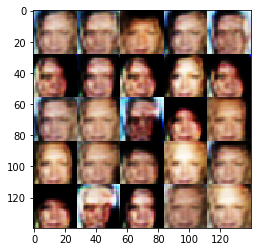

Epoch 1/2 Step 1620... Discriminator Loss: 0.7433... Generator Loss: 1.1647 ... Elapsed Time: 0:10:31.188515
Epoch 1/2 Step 1640... Discriminator Loss: 1.2510... Generator Loss: 0.6592 ... Elapsed Time: 0:10:38.868998
Epoch 1/2 Step 1660... Discriminator Loss: 1.6041... Generator Loss: 0.3485 ... Elapsed Time: 0:10:46.620948
Epoch 1/2 Step 1680... Discriminator Loss: 1.1498... Generator Loss: 0.7763 ... Elapsed Time: 0:10:54.324435
Epoch 1/2 Step 1700... Discriminator Loss: 1.5424... Generator Loss: 2.6430 ... Elapsed Time: 0:11:02.042964
Epoch 1/2 Step 1720... Discriminator Loss: 1.1104... Generator Loss: 0.6843 ... Elapsed Time: 0:11:09.713363
Epoch 1/2 Step 1740... Discriminator Loss: 0.8835... Generator Loss: 1.3327 ... Elapsed Time: 0:11:17.420866
Epoch 1/2 Step 1760... Discriminator Loss: 1.6015... Generator Loss: 0.3146 ... Elapsed Time: 0:11:25.129363
Epoch 1/2 Step 1780... Discriminator Loss: 1.0026... Generator Loss: 0.8613 ... Elapsed Time: 0:11:32.847891
Epoch 1/2 Step 1800

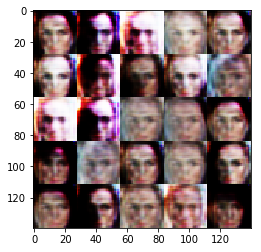

Epoch 1/2 Step 1820... Discriminator Loss: 1.1719... Generator Loss: 0.5010 ... Elapsed Time: 0:11:49.076051
Epoch 1/2 Step 1840... Discriminator Loss: 0.6777... Generator Loss: 1.4978 ... Elapsed Time: 0:11:56.765502
Epoch 1/2 Step 1860... Discriminator Loss: 0.8969... Generator Loss: 1.0474 ... Elapsed Time: 0:12:04.516125
Epoch 1/2 Step 1880... Discriminator Loss: 1.0804... Generator Loss: 0.7473 ... Elapsed Time: 0:12:12.226622
Epoch 1/2 Step 1900... Discriminator Loss: 1.0326... Generator Loss: 0.6919 ... Elapsed Time: 0:12:19.943145
Epoch 1/2 Step 1920... Discriminator Loss: 0.6209... Generator Loss: 1.7800 ... Elapsed Time: 0:12:27.713811
Epoch 1/2 Step 1940... Discriminator Loss: 0.9331... Generator Loss: 0.7690 ... Elapsed Time: 0:12:35.573503
Epoch 1/2 Step 1960... Discriminator Loss: 1.2841... Generator Loss: 2.5488 ... Elapsed Time: 0:12:43.354641
Epoch 1/2 Step 1980... Discriminator Loss: 0.9887... Generator Loss: 0.7407 ... Elapsed Time: 0:12:51.146658
Epoch 1/2 Step 2000

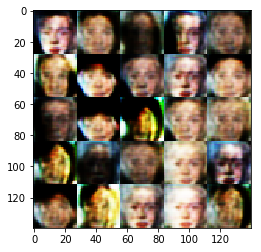

Epoch 1/2 Step 2020... Discriminator Loss: 1.1901... Generator Loss: 0.4164 ... Elapsed Time: 0:13:07.308642
Epoch 1/2 Step 2040... Discriminator Loss: 1.3518... Generator Loss: 1.6259 ... Elapsed Time: 0:13:15.011127
Epoch 1/2 Step 2060... Discriminator Loss: 1.1208... Generator Loss: 0.7694 ... Elapsed Time: 0:13:22.661474
Epoch 1/2 Step 2080... Discriminator Loss: 1.3528... Generator Loss: 1.6867 ... Elapsed Time: 0:13:30.378056
Epoch 1/2 Step 2100... Discriminator Loss: 1.0538... Generator Loss: 0.8096 ... Elapsed Time: 0:13:38.158337
Epoch 1/2 Step 2120... Discriminator Loss: 1.0321... Generator Loss: 0.4790 ... Elapsed Time: 0:13:45.915969
Epoch 1/2 Step 2140... Discriminator Loss: 1.0236... Generator Loss: 1.9175 ... Elapsed Time: 0:13:53.629484
Epoch 1/2 Step 2160... Discriminator Loss: 1.0785... Generator Loss: 0.7349 ... Elapsed Time: 0:14:01.404161
Epoch 1/2 Step 2180... Discriminator Loss: 0.6041... Generator Loss: 1.8709 ... Elapsed Time: 0:14:09.157782
Epoch 1/2 Step 2200

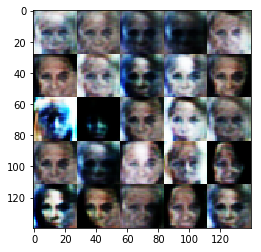

Epoch 1/2 Step 2220... Discriminator Loss: 0.7166... Generator Loss: 1.3653 ... Elapsed Time: 0:14:25.168364
Epoch 1/2 Step 2240... Discriminator Loss: 1.4865... Generator Loss: 0.4839 ... Elapsed Time: 0:14:32.904940
Epoch 1/2 Step 2260... Discriminator Loss: 1.1750... Generator Loss: 0.8241 ... Elapsed Time: 0:14:40.670593
Epoch 1/2 Step 2280... Discriminator Loss: 1.0568... Generator Loss: 1.2440 ... Elapsed Time: 0:14:48.448278
Epoch 1/2 Step 2300... Discriminator Loss: 0.6196... Generator Loss: 1.6182 ... Elapsed Time: 0:14:56.378890
Epoch 1/2 Step 2320... Discriminator Loss: 0.5938... Generator Loss: 1.8319 ... Elapsed Time: 0:15:04.267871
Epoch 1/2 Step 2340... Discriminator Loss: 1.6867... Generator Loss: 0.3052 ... Elapsed Time: 0:15:12.051160
Epoch 1/2 Step 2360... Discriminator Loss: 1.3143... Generator Loss: 0.7294 ... Elapsed Time: 0:15:19.836867
Epoch 1/2 Step 2380... Discriminator Loss: 1.2730... Generator Loss: 0.8750 ... Elapsed Time: 0:15:27.643154
Epoch 1/2 Step 2400

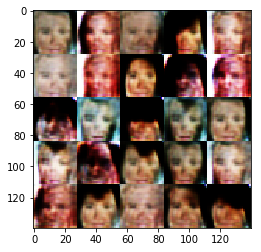

Epoch 1/2 Step 2420... Discriminator Loss: 1.0614... Generator Loss: 1.8215 ... Elapsed Time: 0:15:43.706886
Epoch 1/2 Step 2440... Discriminator Loss: 1.8074... Generator Loss: 0.2705 ... Elapsed Time: 0:15:51.270994
Epoch 1/2 Step 2460... Discriminator Loss: 1.2984... Generator Loss: 0.8048 ... Elapsed Time: 0:15:58.734844
Epoch 1/2 Step 2480... Discriminator Loss: 0.8950... Generator Loss: 0.9046 ... Elapsed Time: 0:16:06.241811
Epoch 1/2 Step 2500... Discriminator Loss: 1.4517... Generator Loss: 0.4795 ... Elapsed Time: 0:16:13.736743
Epoch 1/2 Step 2520... Discriminator Loss: 0.9344... Generator Loss: 1.4128 ... Elapsed Time: 0:16:21.221655
Epoch 1/2 Step 2540... Discriminator Loss: 1.4220... Generator Loss: 0.6488 ... Elapsed Time: 0:16:28.751676
Epoch 1/2 Step 2560... Discriminator Loss: 0.9196... Generator Loss: 0.8756 ... Elapsed Time: 0:16:36.228562
Epoch 1/2 Step 2580... Discriminator Loss: 2.0411... Generator Loss: 0.2394 ... Elapsed Time: 0:16:43.708455
Epoch 1/2 Step 2600

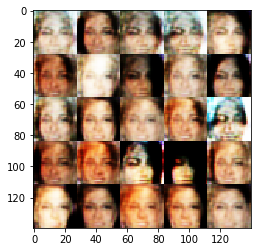

Epoch 1/2 Step 2620... Discriminator Loss: 1.2981... Generator Loss: 0.7173 ... Elapsed Time: 0:16:59.215698
Epoch 1/2 Step 2640... Discriminator Loss: 0.3927... Generator Loss: 1.5375 ... Elapsed Time: 0:17:06.719656
Epoch 1/2 Step 2660... Discriminator Loss: 1.1905... Generator Loss: 0.6433 ... Elapsed Time: 0:17:14.201554
Epoch 1/2 Step 2680... Discriminator Loss: 0.8940... Generator Loss: 1.1237 ... Elapsed Time: 0:17:21.694482
Epoch 1/2 Step 2700... Discriminator Loss: 0.8276... Generator Loss: 1.3143 ... Elapsed Time: 0:17:29.153319
Epoch 1/2 Step 2720... Discriminator Loss: 0.9863... Generator Loss: 0.8683 ... Elapsed Time: 0:17:36.621181
Epoch 1/2 Step 2740... Discriminator Loss: 1.2752... Generator Loss: 0.5653 ... Elapsed Time: 0:17:44.120124
Epoch 1/2 Step 2760... Discriminator Loss: 0.8967... Generator Loss: 1.1813 ... Elapsed Time: 0:17:51.596007
Epoch 1/2 Step 2780... Discriminator Loss: 1.2518... Generator Loss: 0.9322 ... Elapsed Time: 0:17:59.101970
Epoch 1/2 Step 2800

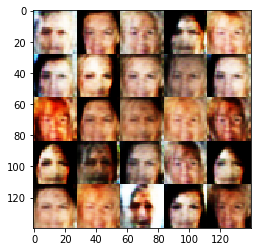

Epoch 1/2 Step 2820... Discriminator Loss: 1.1944... Generator Loss: 0.6583 ... Elapsed Time: 0:18:14.576124
Epoch 1/2 Step 2840... Discriminator Loss: 1.5306... Generator Loss: 0.5333 ... Elapsed Time: 0:18:22.039975
Epoch 1/2 Step 2860... Discriminator Loss: 1.0049... Generator Loss: 2.2907 ... Elapsed Time: 0:18:29.542931
Epoch 1/2 Step 2880... Discriminator Loss: 0.9479... Generator Loss: 1.5657 ... Elapsed Time: 0:18:37.042876
Epoch 1/2 Step 2900... Discriminator Loss: 1.5780... Generator Loss: 0.4048 ... Elapsed Time: 0:18:44.518759
Epoch 1/2 Step 2920... Discriminator Loss: 0.9734... Generator Loss: 1.0774 ... Elapsed Time: 0:18:52.016700
Epoch 1/2 Step 2940... Discriminator Loss: 0.9399... Generator Loss: 0.8816 ... Elapsed Time: 0:18:59.496594
Epoch 1/2 Step 2960... Discriminator Loss: 1.0671... Generator Loss: 1.5592 ... Elapsed Time: 0:19:06.990525
Epoch 1/2 Step 2980... Discriminator Loss: 1.3237... Generator Loss: 0.5657 ... Elapsed Time: 0:19:14.473426
Epoch 1/2 Step 3000

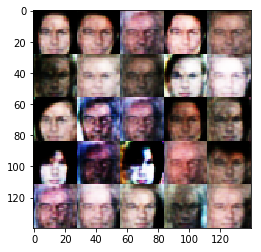

Epoch 1/2 Step 3020... Discriminator Loss: 0.8263... Generator Loss: 1.1358 ... Elapsed Time: 0:19:29.944573
Epoch 1/2 Step 3040... Discriminator Loss: 1.0292... Generator Loss: 0.8889 ... Elapsed Time: 0:19:37.445522
Epoch 1/2 Step 3060... Discriminator Loss: 1.7277... Generator Loss: 0.2922 ... Elapsed Time: 0:19:44.925415
Epoch 1/2 Step 3080... Discriminator Loss: 1.1637... Generator Loss: 0.6111 ... Elapsed Time: 0:19:52.418351
Epoch 1/2 Step 3100... Discriminator Loss: 1.0464... Generator Loss: 1.2001 ... Elapsed Time: 0:19:59.897234
Epoch 1/2 Step 3120... Discriminator Loss: 0.5881... Generator Loss: 1.5317 ... Elapsed Time: 0:20:07.383147
Epoch 1/2 Step 3140... Discriminator Loss: 1.5447... Generator Loss: 0.2708 ... Elapsed Time: 0:20:14.867050
Epoch 1/2 Step 3160... Discriminator Loss: 1.0323... Generator Loss: 0.6397 ... Elapsed Time: 0:20:22.360978
Epoch 1/2 Step 3180... Discriminator Loss: 0.8382... Generator Loss: 1.5451 ... Elapsed Time: 0:20:29.839868
Epoch 1/2 Step 3200

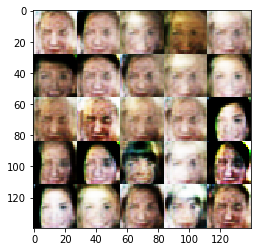

Epoch 1/2 Step 3220... Discriminator Loss: 1.3678... Generator Loss: 0.4510 ... Elapsed Time: 0:20:45.378194
Epoch 1/2 Step 3240... Discriminator Loss: 1.2305... Generator Loss: 0.9926 ... Elapsed Time: 0:20:52.846055
Epoch 1/2 Step 3260... Discriminator Loss: 2.0096... Generator Loss: 0.2361 ... Elapsed Time: 0:21:00.342994
Epoch 1/2 Step 3280... Discriminator Loss: 1.1673... Generator Loss: 0.9851 ... Elapsed Time: 0:21:07.834919
Epoch 1/2 Step 3300... Discriminator Loss: 0.8629... Generator Loss: 1.6210 ... Elapsed Time: 0:21:15.323839
Epoch 1/2 Step 3320... Discriminator Loss: 1.1414... Generator Loss: 0.5464 ... Elapsed Time: 0:21:22.799721
Epoch 1/2 Step 3340... Discriminator Loss: 0.7423... Generator Loss: 1.4266 ... Elapsed Time: 0:21:30.289640
Epoch 1/2 Step 3360... Discriminator Loss: 1.2836... Generator Loss: 0.7227 ... Elapsed Time: 0:21:37.818666
Epoch 1/2 Step 3380... Discriminator Loss: 1.3749... Generator Loss: 0.4465 ... Elapsed Time: 0:21:45.339666
Epoch 1/2 Step 3400

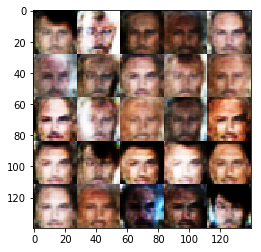

Epoch 1/2 Step 3420... Discriminator Loss: 0.8351... Generator Loss: 1.0122 ... Elapsed Time: 0:22:00.998888
Epoch 1/2 Step 3440... Discriminator Loss: 1.0250... Generator Loss: 0.5851 ... Elapsed Time: 0:22:08.496830
Epoch 1/2 Step 3460... Discriminator Loss: 1.0256... Generator Loss: 0.8515 ... Elapsed Time: 0:22:16.034878
Epoch 1/2 Step 3480... Discriminator Loss: 1.1110... Generator Loss: 0.9192 ... Elapsed Time: 0:22:23.705066
Epoch 1/2 Step 3500... Discriminator Loss: 1.1476... Generator Loss: 0.7875 ... Elapsed Time: 0:22:31.317311
Epoch 1/2 Step 3520... Discriminator Loss: 0.8018... Generator Loss: 1.3529 ... Elapsed Time: 0:22:38.905493
Epoch 1/2 Step 3540... Discriminator Loss: 1.5127... Generator Loss: 0.5739 ... Elapsed Time: 0:22:46.429052
Epoch 1/2 Step 3560... Discriminator Loss: 2.1457... Generator Loss: 0.2443 ... Elapsed Time: 0:22:53.909453
Epoch 1/2 Step 3580... Discriminator Loss: 0.5496... Generator Loss: 2.2472 ... Elapsed Time: 0:23:01.436473
Epoch 1/2 Step 3600

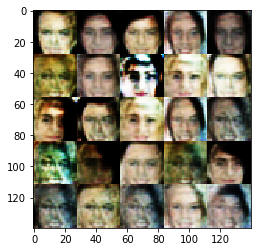

Epoch 1/2 Step 3620... Discriminator Loss: 1.0054... Generator Loss: 1.2434 ... Elapsed Time: 0:23:17.005879
Epoch 1/2 Step 3640... Discriminator Loss: 1.3216... Generator Loss: 0.7065 ... Elapsed Time: 0:23:24.492791
Epoch 1/2 Step 3660... Discriminator Loss: 1.0888... Generator Loss: 1.4649 ... Elapsed Time: 0:23:31.975693
Epoch 1/2 Step 3680... Discriminator Loss: 0.8548... Generator Loss: 1.1224 ... Elapsed Time: 0:23:39.475643
Epoch 1/2 Step 3700... Discriminator Loss: 0.9022... Generator Loss: 1.1642 ... Elapsed Time: 0:23:47.000653
Epoch 1/2 Step 3720... Discriminator Loss: 1.7702... Generator Loss: 0.2610 ... Elapsed Time: 0:23:54.647991
Epoch 1/2 Step 3740... Discriminator Loss: 0.9624... Generator Loss: 0.5969 ... Elapsed Time: 0:24:02.199639
Epoch 1/2 Step 3760... Discriminator Loss: 1.0687... Generator Loss: 0.8699 ... Elapsed Time: 0:24:09.739195
Epoch 1/2 Step 3780... Discriminator Loss: 0.8896... Generator Loss: 1.1057 ... Elapsed Time: 0:24:17.266213
Epoch 1/2 Step 3800

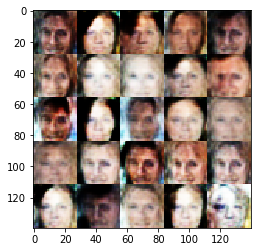

Epoch 1/2 Step 3820... Discriminator Loss: 1.1390... Generator Loss: 1.1539 ... Elapsed Time: 0:24:32.838632
Epoch 1/2 Step 3840... Discriminator Loss: 0.9646... Generator Loss: 0.9107 ... Elapsed Time: 0:24:40.345595
Epoch 1/2 Step 3860... Discriminator Loss: 1.0846... Generator Loss: 0.7637 ... Elapsed Time: 0:24:47.822483
Epoch 1/2 Step 3880... Discriminator Loss: 1.3053... Generator Loss: 0.5390 ... Elapsed Time: 0:24:55.308389
Epoch 1/2 Step 3900... Discriminator Loss: 1.0791... Generator Loss: 0.7306 ... Elapsed Time: 0:25:02.840497
Epoch 1/2 Step 3920... Discriminator Loss: 1.3935... Generator Loss: 0.4333 ... Elapsed Time: 0:25:10.324401
Epoch 1/2 Step 3940... Discriminator Loss: 1.1174... Generator Loss: 1.8276 ... Elapsed Time: 0:25:17.802295
Epoch 1/2 Step 3960... Discriminator Loss: 1.0235... Generator Loss: 0.7766 ... Elapsed Time: 0:25:25.311260
Epoch 1/2 Step 3980... Discriminator Loss: 2.1935... Generator Loss: 0.2207 ... Elapsed Time: 0:25:32.860904
Epoch 1/2 Step 4000

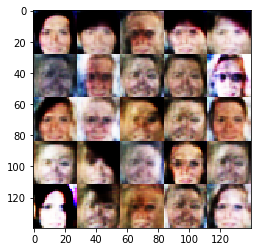

Epoch 1/2 Step 4020... Discriminator Loss: 1.3977... Generator Loss: 0.4098 ... Elapsed Time: 0:25:48.461387
Epoch 1/2 Step 4040... Discriminator Loss: 1.2413... Generator Loss: 0.5475 ... Elapsed Time: 0:25:55.962337
Epoch 1/2 Step 4060... Discriminator Loss: 0.9868... Generator Loss: 0.8654 ... Elapsed Time: 0:26:03.466182
Epoch 1/2 Step 4080... Discriminator Loss: 1.0209... Generator Loss: 1.9928 ... Elapsed Time: 0:26:10.996209
Epoch 1/2 Step 4100... Discriminator Loss: 0.9532... Generator Loss: 1.0285 ... Elapsed Time: 0:26:18.504195
Epoch 1/2 Step 4120... Discriminator Loss: 1.6596... Generator Loss: 0.4271 ... Elapsed Time: 0:26:26.005126
Epoch 1/2 Step 4140... Discriminator Loss: 1.1031... Generator Loss: 0.7573 ... Elapsed Time: 0:26:33.492038
Epoch 1/2 Step 4160... Discriminator Loss: 1.1157... Generator Loss: 0.5097 ... Elapsed Time: 0:26:40.995998
Epoch 1/2 Step 4180... Discriminator Loss: 1.1551... Generator Loss: 1.8627 ... Elapsed Time: 0:26:48.490929
Epoch 1/2 Step 4200

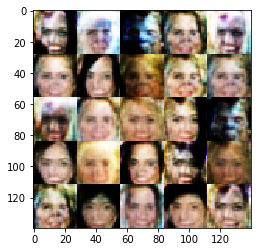

Epoch 1/2 Step 4220... Discriminator Loss: 1.8091... Generator Loss: 0.3755 ... Elapsed Time: 0:27:04.430321
Epoch 1/2 Step 4240... Discriminator Loss: 1.0552... Generator Loss: 0.9687 ... Elapsed Time: 0:27:11.900187
Epoch 1/2 Step 4260... Discriminator Loss: 1.0867... Generator Loss: 0.6710 ... Elapsed Time: 0:27:19.391110
Epoch 1/2 Step 4280... Discriminator Loss: 0.9157... Generator Loss: 0.8998 ... Elapsed Time: 0:27:26.864908
Epoch 1/2 Step 4300... Discriminator Loss: 1.2877... Generator Loss: 0.4058 ... Elapsed Time: 0:27:34.432108
Epoch 1/2 Step 4320... Discriminator Loss: 1.2359... Generator Loss: 0.6139 ... Elapsed Time: 0:27:42.011859
Epoch 1/2 Step 4340... Discriminator Loss: 0.8793... Generator Loss: 0.6398 ... Elapsed Time: 0:27:49.554499
Epoch 1/2 Step 4360... Discriminator Loss: 1.7724... Generator Loss: 0.3215 ... Elapsed Time: 0:27:57.040427
Epoch 1/2 Step 4380... Discriminator Loss: 0.7244... Generator Loss: 1.2316 ... Elapsed Time: 0:28:04.521304
Epoch 1/2 Step 4400

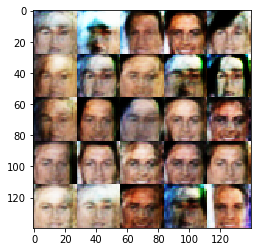

Epoch 1/2 Step 4420... Discriminator Loss: 1.2322... Generator Loss: 0.9228 ... Elapsed Time: 0:28:20.095725
Epoch 1/2 Step 4440... Discriminator Loss: 1.2178... Generator Loss: 0.6691 ... Elapsed Time: 0:28:27.599683
Epoch 1/2 Step 4460... Discriminator Loss: 1.0087... Generator Loss: 0.8598 ... Elapsed Time: 0:28:35.076568
Epoch 1/2 Step 4480... Discriminator Loss: 0.7503... Generator Loss: 1.1562 ... Elapsed Time: 0:28:42.568494
Epoch 1/2 Step 4500... Discriminator Loss: 1.5083... Generator Loss: 0.4214 ... Elapsed Time: 0:28:50.048391
Epoch 1/2 Step 4520... Discriminator Loss: 1.5535... Generator Loss: 0.3295 ... Elapsed Time: 0:28:57.582424
Epoch 1/2 Step 4540... Discriminator Loss: 1.2535... Generator Loss: 2.0951 ... Elapsed Time: 0:29:05.085379
Epoch 1/2 Step 4560... Discriminator Loss: 1.2139... Generator Loss: 0.4698 ... Elapsed Time: 0:29:12.627030
Epoch 1/2 Step 4580... Discriminator Loss: 1.0485... Generator Loss: 1.3273 ... Elapsed Time: 0:29:20.133996
Epoch 1/2 Step 4600

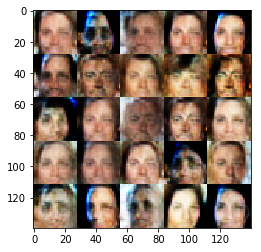

Epoch 1/2 Step 4620... Discriminator Loss: 0.9360... Generator Loss: 0.5332 ... Elapsed Time: 0:29:35.723457
Epoch 1/2 Step 4640... Discriminator Loss: 1.4016... Generator Loss: 0.4852 ... Elapsed Time: 0:29:43.207361
Epoch 1/2 Step 4660... Discriminator Loss: 1.1926... Generator Loss: 1.3593 ... Elapsed Time: 0:29:50.691265
Epoch 1/2 Step 4680... Discriminator Loss: 1.4949... Generator Loss: 0.5054 ... Elapsed Time: 0:29:58.182187
Epoch 1/2 Step 4700... Discriminator Loss: 0.6526... Generator Loss: 1.1518 ... Elapsed Time: 0:30:05.729260
Epoch 1/2 Step 4720... Discriminator Loss: 1.0637... Generator Loss: 0.8394 ... Elapsed Time: 0:30:13.229216
Epoch 1/2 Step 4740... Discriminator Loss: 0.9478... Generator Loss: 1.3203 ... Elapsed Time: 0:30:20.730155
Epoch 1/2 Step 4760... Discriminator Loss: 1.7517... Generator Loss: 0.2175 ... Elapsed Time: 0:30:28.223083
Epoch 1/2 Step 4780... Discriminator Loss: 1.7073... Generator Loss: 0.4236 ... Elapsed Time: 0:30:35.735061
Epoch 1/2 Step 4800

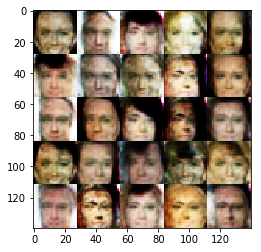

Epoch 1/2 Step 4820... Discriminator Loss: 0.9085... Generator Loss: 1.4057 ... Elapsed Time: 0:30:51.440833
Epoch 1/2 Step 4840... Discriminator Loss: 0.8262... Generator Loss: 0.9433 ... Elapsed Time: 0:30:58.919723
Epoch 1/2 Step 4860... Discriminator Loss: 1.3177... Generator Loss: 0.8938 ... Elapsed Time: 0:31:06.378561
Epoch 1/2 Step 4880... Discriminator Loss: 0.9971... Generator Loss: 1.2625 ... Elapsed Time: 0:31:13.863468
Epoch 1/2 Step 4900... Discriminator Loss: 0.9758... Generator Loss: 1.0141 ... Elapsed Time: 0:31:21.353388
Epoch 1/2 Step 4920... Discriminator Loss: 1.4250... Generator Loss: 0.3803 ... Elapsed Time: 0:31:28.837291
Epoch 1/2 Step 4940... Discriminator Loss: 0.8154... Generator Loss: 1.3629 ... Elapsed Time: 0:31:36.331222
Epoch 1/2 Step 4960... Discriminator Loss: 0.6782... Generator Loss: 1.1440 ... Elapsed Time: 0:31:43.832172
Epoch 1/2 Step 4980... Discriminator Loss: 0.9623... Generator Loss: 0.9018 ... Elapsed Time: 0:31:51.281985
Epoch 1/2 Step 5000

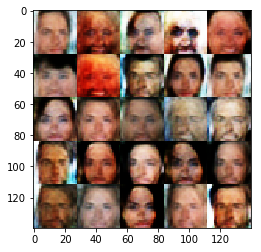

Epoch 1/2 Step 5020... Discriminator Loss: 1.3304... Generator Loss: 0.3541 ... Elapsed Time: 0:32:06.798252
Epoch 1/2 Step 5040... Discriminator Loss: 1.3513... Generator Loss: 0.6659 ... Elapsed Time: 0:32:14.305217
Epoch 1/2 Step 5060... Discriminator Loss: 1.1284... Generator Loss: 0.7760 ... Elapsed Time: 0:32:21.782102
Epoch 1/2 Step 5080... Discriminator Loss: 0.7394... Generator Loss: 0.7575 ... Elapsed Time: 0:32:29.286060
Epoch 1/2 Step 5100... Discriminator Loss: 1.4794... Generator Loss: 1.6407 ... Elapsed Time: 0:32:36.743894
Epoch 1/2 Step 5120... Discriminator Loss: 0.8437... Generator Loss: 1.3358 ... Elapsed Time: 0:32:44.222785
Epoch 1/2 Step 5140... Discriminator Loss: 1.9903... Generator Loss: 0.2877 ... Elapsed Time: 0:32:51.737772
Epoch 1/2 Step 5160... Discriminator Loss: 1.0015... Generator Loss: 0.9040 ... Elapsed Time: 0:32:59.236716
Epoch 1/2 Step 5180... Discriminator Loss: 0.9409... Generator Loss: 1.3097 ... Elapsed Time: 0:33:06.727641
Epoch 1/2 Step 5200

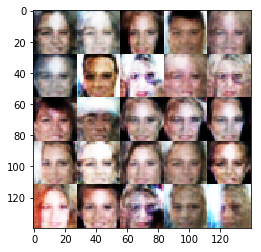

Epoch 1/2 Step 5220... Discriminator Loss: 1.2816... Generator Loss: 0.5676 ... Elapsed Time: 0:33:22.337499
Epoch 1/2 Step 5240... Discriminator Loss: 1.5086... Generator Loss: 0.7100 ... Elapsed Time: 0:33:30.059784
Epoch 1/2 Step 5260... Discriminator Loss: 1.2181... Generator Loss: 0.6199 ... Elapsed Time: 0:33:37.587810
Epoch 1/2 Step 5280... Discriminator Loss: 0.9247... Generator Loss: 0.7546 ... Elapsed Time: 0:33:45.064695
Epoch 1/2 Step 5300... Discriminator Loss: 0.8293... Generator Loss: 1.3652 ... Elapsed Time: 0:33:52.544588
Epoch 1/2 Step 5320... Discriminator Loss: 1.1303... Generator Loss: 0.5376 ... Elapsed Time: 0:34:00.157569
Epoch 1/2 Step 5340... Discriminator Loss: 1.2210... Generator Loss: 0.7296 ... Elapsed Time: 0:34:08.034738
Epoch 1/2 Step 5360... Discriminator Loss: 1.1647... Generator Loss: 0.5609 ... Elapsed Time: 0:34:15.604376
Epoch 1/2 Step 5380... Discriminator Loss: 0.8839... Generator Loss: 1.7335 ... Elapsed Time: 0:34:23.243698
Epoch 1/2 Step 5400

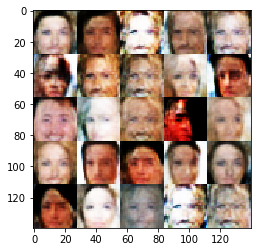

Epoch 1/2 Step 5420... Discriminator Loss: 0.8741... Generator Loss: 1.2407 ... Elapsed Time: 0:34:38.859224
Epoch 1/2 Step 5440... Discriminator Loss: 1.1675... Generator Loss: 0.5587 ... Elapsed Time: 0:34:46.344131
Epoch 1/2 Step 5460... Discriminator Loss: 1.3721... Generator Loss: 0.4340 ... Elapsed Time: 0:34:53.826029
Epoch 1/2 Step 5480... Discriminator Loss: 1.1411... Generator Loss: 0.5675 ... Elapsed Time: 0:35:01.313944
Epoch 1/2 Step 5500... Discriminator Loss: 1.7018... Generator Loss: 0.3030 ... Elapsed Time: 0:35:08.811886
Epoch 1/2 Step 5520... Discriminator Loss: 1.2908... Generator Loss: 0.7458 ... Elapsed Time: 0:35:16.404663
Epoch 1/2 Step 5540... Discriminator Loss: 0.8662... Generator Loss: 0.6906 ... Elapsed Time: 0:35:23.907617
Epoch 1/2 Step 5560... Discriminator Loss: 1.2333... Generator Loss: 1.4946 ... Elapsed Time: 0:35:31.413580
Epoch 1/2 Step 5580... Discriminator Loss: 0.8378... Generator Loss: 1.4990 ... Elapsed Time: 0:35:38.919543
Epoch 1/2 Step 5600

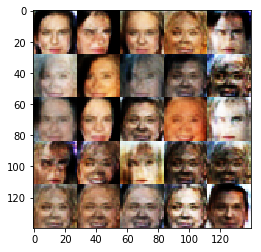

Epoch 1/2 Step 5620... Discriminator Loss: 1.2193... Generator Loss: 0.5538 ... Elapsed Time: 0:35:54.479927
Epoch 1/2 Step 5640... Discriminator Loss: 0.9734... Generator Loss: 0.7489 ... Elapsed Time: 0:36:01.989900
Epoch 1/2 Step 5660... Discriminator Loss: 0.9097... Generator Loss: 1.2039 ... Elapsed Time: 0:36:09.490849
Epoch 1/2 Step 5680... Discriminator Loss: 0.8006... Generator Loss: 0.9528 ... Elapsed Time: 0:36:16.987788
Epoch 1/2 Step 5700... Discriminator Loss: 1.2372... Generator Loss: 0.7634 ... Elapsed Time: 0:36:24.449633
Epoch 1/2 Step 5720... Discriminator Loss: 0.7944... Generator Loss: 1.3437 ... Elapsed Time: 0:36:31.902454
Epoch 1/2 Step 5740... Discriminator Loss: 1.1963... Generator Loss: 0.8516 ... Elapsed Time: 0:36:39.366305
Epoch 1/2 Step 5760... Discriminator Loss: 1.7814... Generator Loss: 0.3512 ... Elapsed Time: 0:36:46.868262
Epoch 1/2 Step 5780... Discriminator Loss: 1.4368... Generator Loss: 0.4541 ... Elapsed Time: 0:36:54.348150
Epoch 1/2 Step 5800

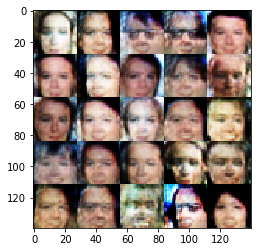

Epoch 1/2 Step 5820... Discriminator Loss: 1.4577... Generator Loss: 0.4542 ... Elapsed Time: 0:37:09.933601
Epoch 1/2 Step 5840... Discriminator Loss: 0.8623... Generator Loss: 1.4033 ... Elapsed Time: 0:37:17.457100
Epoch 1/2 Step 5860... Discriminator Loss: 0.9382... Generator Loss: 1.3872 ... Elapsed Time: 0:37:24.940001
Epoch 1/2 Step 5880... Discriminator Loss: 0.7804... Generator Loss: 1.4470 ... Elapsed Time: 0:37:32.424908
Epoch 1/2 Step 5900... Discriminator Loss: 0.9781... Generator Loss: 0.8833 ... Elapsed Time: 0:37:39.908812
Epoch 1/2 Step 5920... Discriminator Loss: 1.2236... Generator Loss: 0.5758 ... Elapsed Time: 0:37:47.412769
Epoch 1/2 Step 5940... Discriminator Loss: 0.9463... Generator Loss: 0.7319 ... Elapsed Time: 0:37:54.898678
Epoch 1/2 Step 5960... Discriminator Loss: 1.0331... Generator Loss: 0.7593 ... Elapsed Time: 0:38:02.370550
Epoch 1/2 Step 5980... Discriminator Loss: 1.0212... Generator Loss: 1.2215 ... Elapsed Time: 0:38:09.857462
Epoch 1/2 Step 6000

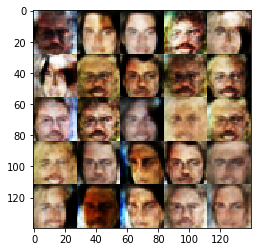

Epoch 1/2 Step 6020... Discriminator Loss: 0.9270... Generator Loss: 1.0309 ... Elapsed Time: 0:38:25.486588
Epoch 1/2 Step 6040... Discriminator Loss: 1.0587... Generator Loss: 0.9408 ... Elapsed Time: 0:38:33.080884
Epoch 1/2 Step 6060... Discriminator Loss: 1.7006... Generator Loss: 0.3319 ... Elapsed Time: 0:38:40.557769
Epoch 1/2 Step 6080... Discriminator Loss: 0.9348... Generator Loss: 0.9873 ... Elapsed Time: 0:38:48.087799
Epoch 1/2 Step 6100... Discriminator Loss: 1.6581... Generator Loss: 0.4718 ... Elapsed Time: 0:38:55.566686
Epoch 1/2 Step 6120... Discriminator Loss: 1.3712... Generator Loss: 0.4835 ... Elapsed Time: 0:39:03.101726
Epoch 1/2 Step 6140... Discriminator Loss: 0.9332... Generator Loss: 0.6733 ... Elapsed Time: 0:39:10.714974
Epoch 1/2 Step 6160... Discriminator Loss: 1.0349... Generator Loss: 1.2743 ... Elapsed Time: 0:39:18.227955
Epoch 1/2 Step 6180... Discriminator Loss: 1.2258... Generator Loss: 0.4525 ... Elapsed Time: 0:39:25.729907
Epoch 1/2 Step 6200

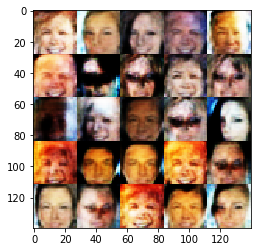

Epoch 1/2 Step 6220... Discriminator Loss: 1.0940... Generator Loss: 1.0910 ... Elapsed Time: 0:39:41.301321
Epoch 1/2 Step 6240... Discriminator Loss: 1.3691... Generator Loss: 0.3825 ... Elapsed Time: 0:39:48.764169
Epoch 1/2 Step 6260... Discriminator Loss: 1.1585... Generator Loss: 0.5452 ... Elapsed Time: 0:39:56.307230
Epoch 1/2 Step 6280... Discriminator Loss: 1.1117... Generator Loss: 1.5455 ... Elapsed Time: 0:40:03.909451
Epoch 1/2 Step 6300... Discriminator Loss: 1.0254... Generator Loss: 0.6783 ... Elapsed Time: 0:40:11.511776
Epoch 1/2 Step 6320... Discriminator Loss: 0.5748... Generator Loss: 2.0597 ... Elapsed Time: 0:40:19.012719
Epoch 2/2 Step 6340... Discriminator Loss: 1.4346... Generator Loss: 0.4899 ... Elapsed Time: 0:40:26.565807
Epoch 2/2 Step 6360... Discriminator Loss: 0.8732... Generator Loss: 1.2107 ... Elapsed Time: 0:40:34.142001
Epoch 2/2 Step 6380... Discriminator Loss: 0.7767... Generator Loss: 1.5400 ... Elapsed Time: 0:40:41.718150
Epoch 2/2 Step 6400

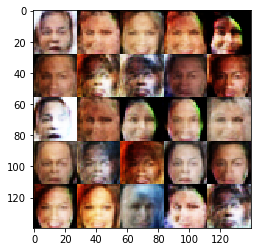

Epoch 2/2 Step 6420... Discriminator Loss: 1.0051... Generator Loss: 0.7720 ... Elapsed Time: 0:40:57.404444
Epoch 2/2 Step 6440... Discriminator Loss: 0.9839... Generator Loss: 0.8431 ... Elapsed Time: 0:41:04.929454
Epoch 2/2 Step 6460... Discriminator Loss: 1.1791... Generator Loss: 0.4614 ... Elapsed Time: 0:41:12.466500
Epoch 2/2 Step 6480... Discriminator Loss: 1.1751... Generator Loss: 0.6526 ... Elapsed Time: 0:41:19.940377
Epoch 2/2 Step 6500... Discriminator Loss: 1.1334... Generator Loss: 0.8006 ... Elapsed Time: 0:41:27.478427
Epoch 2/2 Step 6520... Discriminator Loss: 1.1385... Generator Loss: 0.7600 ... Elapsed Time: 0:41:34.989401
Epoch 2/2 Step 6540... Discriminator Loss: 1.2085... Generator Loss: 0.5864 ... Elapsed Time: 0:41:42.485337
Epoch 2/2 Step 6560... Discriminator Loss: 0.9086... Generator Loss: 1.4793 ... Elapsed Time: 0:41:49.945177
Epoch 2/2 Step 6580... Discriminator Loss: 0.7743... Generator Loss: 1.2321 ... Elapsed Time: 0:41:57.418051
Epoch 2/2 Step 6600

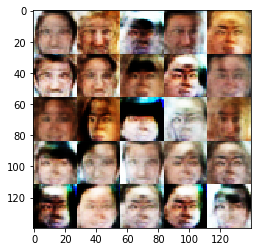

Epoch 2/2 Step 6620... Discriminator Loss: 1.6704... Generator Loss: 0.3070 ... Elapsed Time: 0:42:13.300761
Epoch 2/2 Step 6640... Discriminator Loss: 1.1562... Generator Loss: 0.5705 ... Elapsed Time: 0:42:20.837801
Epoch 2/2 Step 6660... Discriminator Loss: 1.0516... Generator Loss: 1.9558 ... Elapsed Time: 0:42:28.347774
Epoch 2/2 Step 6680... Discriminator Loss: 1.5829... Generator Loss: 0.3115 ... Elapsed Time: 0:42:35.934796
Epoch 2/2 Step 6700... Discriminator Loss: 0.9735... Generator Loss: 1.5508 ... Elapsed Time: 0:42:43.473846
Epoch 2/2 Step 6720... Discriminator Loss: 0.8831... Generator Loss: 1.0674 ... Elapsed Time: 0:42:50.985827
Epoch 2/2 Step 6740... Discriminator Loss: 1.1234... Generator Loss: 1.1490 ... Elapsed Time: 0:42:58.463713
Epoch 2/2 Step 6760... Discriminator Loss: 0.6915... Generator Loss: 1.1321 ... Elapsed Time: 0:43:05.972684
Epoch 2/2 Step 6780... Discriminator Loss: 1.1312... Generator Loss: 0.6984 ... Elapsed Time: 0:43:13.458595
Epoch 2/2 Step 6800

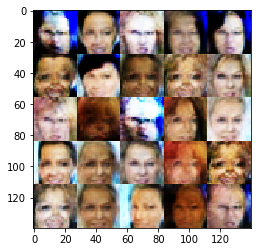

Epoch 2/2 Step 6820... Discriminator Loss: 1.2129... Generator Loss: 0.5436 ... Elapsed Time: 0:43:29.389964
Epoch 2/2 Step 6840... Discriminator Loss: 1.3434... Generator Loss: 0.5105 ... Elapsed Time: 0:43:36.890913
Epoch 2/2 Step 6860... Discriminator Loss: 0.8454... Generator Loss: 1.3679 ... Elapsed Time: 0:43:44.392865
Epoch 2/2 Step 6880... Discriminator Loss: 1.4260... Generator Loss: 0.3313 ... Elapsed Time: 0:43:51.886795
Epoch 2/2 Step 6900... Discriminator Loss: 1.0972... Generator Loss: 0.8323 ... Elapsed Time: 0:43:59.379724
Epoch 2/2 Step 6920... Discriminator Loss: 1.0668... Generator Loss: 0.6346 ... Elapsed Time: 0:44:06.849591
Epoch 2/2 Step 6940... Discriminator Loss: 0.9378... Generator Loss: 0.9806 ... Elapsed Time: 0:44:14.321467
Epoch 2/2 Step 6960... Discriminator Loss: 1.3464... Generator Loss: 0.4851 ... Elapsed Time: 0:44:21.832438
Epoch 2/2 Step 6980... Discriminator Loss: 1.7040... Generator Loss: 0.3411 ... Elapsed Time: 0:44:29.294290
Epoch 2/2 Step 7000

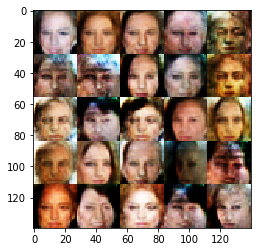

Epoch 2/2 Step 7020... Discriminator Loss: 1.2149... Generator Loss: 0.6570 ... Elapsed Time: 0:44:44.911820
Epoch 2/2 Step 7040... Discriminator Loss: 0.8204... Generator Loss: 0.9755 ... Elapsed Time: 0:44:52.401740
Epoch 2/2 Step 7060... Discriminator Loss: 1.0503... Generator Loss: 1.5917 ... Elapsed Time: 0:44:59.890661
Epoch 2/2 Step 7080... Discriminator Loss: 0.9498... Generator Loss: 0.7938 ... Elapsed Time: 0:45:07.401633
Epoch 2/2 Step 7100... Discriminator Loss: 0.8983... Generator Loss: 0.9773 ... Elapsed Time: 0:45:14.985892
Epoch 2/2 Step 7120... Discriminator Loss: 1.2312... Generator Loss: 1.0007 ... Elapsed Time: 0:45:22.552283
Epoch 2/2 Step 7140... Discriminator Loss: 1.3169... Generator Loss: 0.4827 ... Elapsed Time: 0:45:30.092334
Epoch 2/2 Step 7160... Discriminator Loss: 0.6993... Generator Loss: 1.0486 ... Elapsed Time: 0:45:37.602307
Epoch 2/2 Step 7180... Discriminator Loss: 1.1855... Generator Loss: 1.1621 ... Elapsed Time: 0:45:45.098239
Epoch 2/2 Step 7200

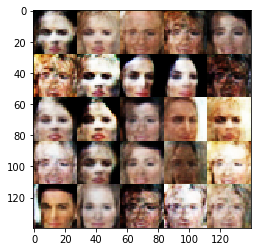

Epoch 2/2 Step 7220... Discriminator Loss: 0.9637... Generator Loss: 1.1208 ... Elapsed Time: 0:46:00.726804
Epoch 2/2 Step 7240... Discriminator Loss: 0.9401... Generator Loss: 0.9390 ... Elapsed Time: 0:46:08.272874
Epoch 2/2 Step 7260... Discriminator Loss: 1.1571... Generator Loss: 0.6493 ... Elapsed Time: 0:46:15.785855
Epoch 2/2 Step 7280... Discriminator Loss: 1.5748... Generator Loss: 0.3761 ... Elapsed Time: 0:46:23.268756
Epoch 2/2 Step 7300... Discriminator Loss: 0.9196... Generator Loss: 1.0649 ... Elapsed Time: 0:46:30.773716
Epoch 2/2 Step 7320... Discriminator Loss: 1.0983... Generator Loss: 0.8022 ... Elapsed Time: 0:46:38.259625
Epoch 2/2 Step 7340... Discriminator Loss: 0.7671... Generator Loss: 0.9940 ... Elapsed Time: 0:46:45.771604
Epoch 2/2 Step 7360... Discriminator Loss: 1.7311... Generator Loss: 0.3070 ... Elapsed Time: 0:46:53.266540
Epoch 2/2 Step 7380... Discriminator Loss: 0.9903... Generator Loss: 0.7964 ... Elapsed Time: 0:47:00.793556
Epoch 2/2 Step 7400

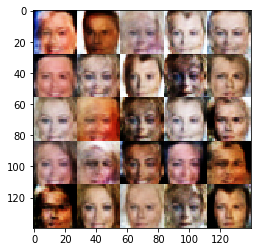

Epoch 2/2 Step 7420... Discriminator Loss: 0.8131... Generator Loss: 1.0212 ... Elapsed Time: 0:47:16.418379
Epoch 2/2 Step 7440... Discriminator Loss: 0.9839... Generator Loss: 1.5299 ... Elapsed Time: 0:47:23.896984
Epoch 2/2 Step 7460... Discriminator Loss: 1.0162... Generator Loss: 1.2110 ... Elapsed Time: 0:47:31.392129
Epoch 2/2 Step 7480... Discriminator Loss: 1.1267... Generator Loss: 0.7149 ... Elapsed Time: 0:47:38.890070
Epoch 2/2 Step 7500... Discriminator Loss: 1.4086... Generator Loss: 0.5719 ... Elapsed Time: 0:47:46.353921
Epoch 2/2 Step 7520... Discriminator Loss: 0.9907... Generator Loss: 0.8584 ... Elapsed Time: 0:47:53.859886
Epoch 2/2 Step 7540... Discriminator Loss: 1.4063... Generator Loss: 0.5315 ... Elapsed Time: 0:48:01.354817
Epoch 2/2 Step 7560... Discriminator Loss: 1.1030... Generator Loss: 1.9492 ... Elapsed Time: 0:48:08.835713
Epoch 2/2 Step 7580... Discriminator Loss: 1.7186... Generator Loss: 0.3635 ... Elapsed Time: 0:48:16.334657
Epoch 2/2 Step 7600

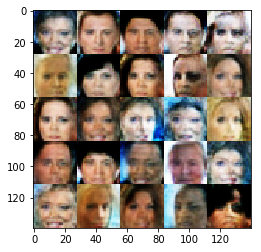

Epoch 2/2 Step 7620... Discriminator Loss: 0.7163... Generator Loss: 2.5239 ... Elapsed Time: 0:48:31.978262
Epoch 2/2 Step 7640... Discriminator Loss: 0.9815... Generator Loss: 0.9195 ... Elapsed Time: 0:48:39.459159
Epoch 2/2 Step 7660... Discriminator Loss: 1.9299... Generator Loss: 0.2850 ... Elapsed Time: 0:48:46.928022
Epoch 2/2 Step 7680... Discriminator Loss: 0.8385... Generator Loss: 0.7281 ... Elapsed Time: 0:48:54.445014
Epoch 2/2 Step 7700... Discriminator Loss: 0.8968... Generator Loss: 1.2984 ... Elapsed Time: 0:49:01.939948
Epoch 2/2 Step 7720... Discriminator Loss: 1.2833... Generator Loss: 0.5527 ... Elapsed Time: 0:49:09.438892
Epoch 2/2 Step 7740... Discriminator Loss: 1.0976... Generator Loss: 0.7802 ... Elapsed Time: 0:49:16.947863
Epoch 2/2 Step 7760... Discriminator Loss: 1.1095... Generator Loss: 0.7422 ... Elapsed Time: 0:49:24.435777
Epoch 2/2 Step 7780... Discriminator Loss: 1.8954... Generator Loss: 0.2815 ... Elapsed Time: 0:49:31.907650
Epoch 2/2 Step 7800

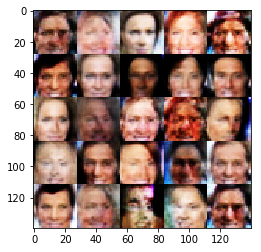

Epoch 2/2 Step 7820... Discriminator Loss: 0.8669... Generator Loss: 0.8314 ... Elapsed Time: 0:49:47.673655
Epoch 2/2 Step 7840... Discriminator Loss: 0.8771... Generator Loss: 0.9259 ... Elapsed Time: 0:49:55.300671
Epoch 2/2 Step 7860... Discriminator Loss: 0.8579... Generator Loss: 1.0495 ... Elapsed Time: 0:50:02.871808
Epoch 2/2 Step 7880... Discriminator Loss: 0.9343... Generator Loss: 0.9110 ... Elapsed Time: 0:50:10.401834
Epoch 2/2 Step 7900... Discriminator Loss: 1.1102... Generator Loss: 0.5482 ... Elapsed Time: 0:50:17.908799
Epoch 2/2 Step 7920... Discriminator Loss: 0.7181... Generator Loss: 0.9480 ... Elapsed Time: 0:50:25.409749
Epoch 2/2 Step 7940... Discriminator Loss: 1.2462... Generator Loss: 0.5250 ... Elapsed Time: 0:50:32.896663
Epoch 2/2 Step 7960... Discriminator Loss: 1.1238... Generator Loss: 0.7510 ... Elapsed Time: 0:50:40.378559
Epoch 2/2 Step 7980... Discriminator Loss: 0.9784... Generator Loss: 0.7916 ... Elapsed Time: 0:50:47.887530
Epoch 2/2 Step 8000

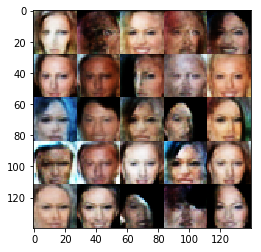

Epoch 2/2 Step 8020... Discriminator Loss: 1.7253... Generator Loss: 0.4268 ... Elapsed Time: 0:51:03.516919
Epoch 2/2 Step 8040... Discriminator Loss: 1.1422... Generator Loss: 0.7594 ... Elapsed Time: 0:51:11.026900
Epoch 2/2 Step 8060... Discriminator Loss: 0.9711... Generator Loss: 1.3137 ... Elapsed Time: 0:51:18.525836
Epoch 2/2 Step 8080... Discriminator Loss: 0.6399... Generator Loss: 1.1040 ... Elapsed Time: 0:51:26.025799
Epoch 2/2 Step 8100... Discriminator Loss: 0.9081... Generator Loss: 0.7432 ... Elapsed Time: 0:51:33.520716
Epoch 2/2 Step 8120... Discriminator Loss: 1.1434... Generator Loss: 0.5145 ... Elapsed Time: 0:51:41.019660
Epoch 2/2 Step 8140... Discriminator Loss: 1.6134... Generator Loss: 0.4403 ... Elapsed Time: 0:51:48.519607
Epoch 2/2 Step 8160... Discriminator Loss: 1.1980... Generator Loss: 0.6070 ... Elapsed Time: 0:51:56.016546
Epoch 2/2 Step 8180... Discriminator Loss: 0.9810... Generator Loss: 0.8902 ... Elapsed Time: 0:52:03.498444
Epoch 2/2 Step 8200

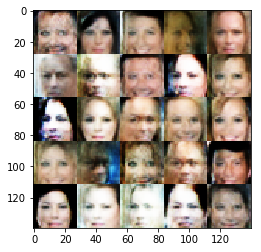

Epoch 2/2 Step 8220... Discriminator Loss: 0.8170... Generator Loss: 1.7778 ... Elapsed Time: 0:52:19.138139
Epoch 2/2 Step 8240... Discriminator Loss: 0.8830... Generator Loss: 1.0493 ... Elapsed Time: 0:52:26.646108
Epoch 2/2 Step 8260... Discriminator Loss: 1.5961... Generator Loss: 0.3698 ... Elapsed Time: 0:52:34.284993
Epoch 2/2 Step 8280... Discriminator Loss: 1.6117... Generator Loss: 0.3189 ... Elapsed Time: 0:52:41.814936
Epoch 2/2 Step 8300... Discriminator Loss: 1.2286... Generator Loss: 0.4737 ... Elapsed Time: 0:52:49.355996
Epoch 2/2 Step 8320... Discriminator Loss: 1.9229... Generator Loss: 0.2572 ... Elapsed Time: 0:52:57.000322
Epoch 2/2 Step 8340... Discriminator Loss: 0.9303... Generator Loss: 0.7331 ... Elapsed Time: 0:53:04.501271
Epoch 2/2 Step 8360... Discriminator Loss: 1.0359... Generator Loss: 0.7646 ... Elapsed Time: 0:53:11.985176
Epoch 2/2 Step 8380... Discriminator Loss: 1.3797... Generator Loss: 0.5690 ... Elapsed Time: 0:53:19.485122
Epoch 2/2 Step 8400

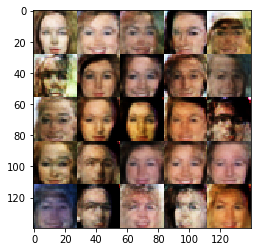

Epoch 2/2 Step 8420... Discriminator Loss: 1.1155... Generator Loss: 1.0489 ... Elapsed Time: 0:53:35.190125
Epoch 2/2 Step 8440... Discriminator Loss: 0.9765... Generator Loss: 1.4402 ... Elapsed Time: 0:53:42.671021
Epoch 2/2 Step 8460... Discriminator Loss: 0.8967... Generator Loss: 0.8469 ... Elapsed Time: 0:53:50.156931
Epoch 2/2 Step 8480... Discriminator Loss: 1.2357... Generator Loss: 0.3563 ... Elapsed Time: 0:53:57.637826
Epoch 2/2 Step 8500... Discriminator Loss: 0.8067... Generator Loss: 1.3494 ... Elapsed Time: 0:54:05.114712
Epoch 2/2 Step 8520... Discriminator Loss: 1.2490... Generator Loss: 0.5429 ... Elapsed Time: 0:54:12.621678
Epoch 2/2 Step 8540... Discriminator Loss: 1.4021... Generator Loss: 0.3929 ... Elapsed Time: 0:54:20.101570
Epoch 2/2 Step 8560... Discriminator Loss: 1.1693... Generator Loss: 0.4193 ... Elapsed Time: 0:54:27.617560
Epoch 2/2 Step 8580... Discriminator Loss: 1.3065... Generator Loss: 0.5293 ... Elapsed Time: 0:54:35.084419
Epoch 2/2 Step 8600

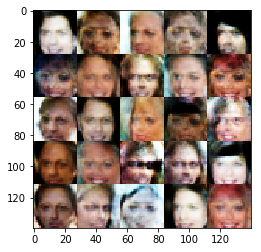

Epoch 2/2 Step 8620... Discriminator Loss: 1.3678... Generator Loss: 0.5513 ... Elapsed Time: 0:54:50.726018
Epoch 2/2 Step 8640... Discriminator Loss: 0.8492... Generator Loss: 1.3733 ... Elapsed Time: 0:54:58.208920
Epoch 2/2 Step 8660... Discriminator Loss: 0.7433... Generator Loss: 1.0564 ... Elapsed Time: 0:55:05.692824
Epoch 2/2 Step 8680... Discriminator Loss: 0.9158... Generator Loss: 0.7934 ... Elapsed Time: 0:55:13.209816
Epoch 2/2 Step 8700... Discriminator Loss: 1.4197... Generator Loss: 0.5358 ... Elapsed Time: 0:55:20.683693
Epoch 2/2 Step 8720... Discriminator Loss: 0.9999... Generator Loss: 0.5637 ... Elapsed Time: 0:55:28.219736
Epoch 2/2 Step 8740... Discriminator Loss: 0.9466... Generator Loss: 0.9771 ... Elapsed Time: 0:55:35.718680
Epoch 2/2 Step 8760... Discriminator Loss: 1.1355... Generator Loss: 0.5689 ... Elapsed Time: 0:55:43.370203
Epoch 2/2 Step 8780... Discriminator Loss: 1.1643... Generator Loss: 1.6185 ... Elapsed Time: 0:55:51.009099
Epoch 2/2 Step 8800

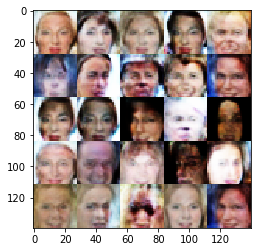

Epoch 2/2 Step 8820... Discriminator Loss: 0.8598... Generator Loss: 1.3145 ... Elapsed Time: 0:56:06.626635
Epoch 2/2 Step 8840... Discriminator Loss: 1.7166... Generator Loss: 0.3329 ... Elapsed Time: 0:56:14.192758
Epoch 2/2 Step 8860... Discriminator Loss: 0.8959... Generator Loss: 0.9373 ... Elapsed Time: 0:56:21.685686
Epoch 2/2 Step 8880... Discriminator Loss: 0.9800... Generator Loss: 0.6379 ... Elapsed Time: 0:56:29.147531
Epoch 2/2 Step 8900... Discriminator Loss: 1.0602... Generator Loss: 0.6403 ... Elapsed Time: 0:56:36.633440
Epoch 2/2 Step 8920... Discriminator Loss: 1.3595... Generator Loss: 0.7669 ... Elapsed Time: 0:56:44.112331
Epoch 2/2 Step 8940... Discriminator Loss: 1.4253... Generator Loss: 0.5201 ... Elapsed Time: 0:56:51.629323
Epoch 2/2 Step 8960... Discriminator Loss: 0.8716... Generator Loss: 0.9360 ... Elapsed Time: 0:56:59.132280
Epoch 2/2 Step 8980... Discriminator Loss: 1.2548... Generator Loss: 0.8243 ... Elapsed Time: 0:57:06.614177
Epoch 2/2 Step 9000

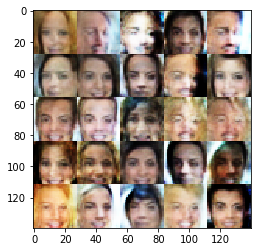

Epoch 2/2 Step 9020... Discriminator Loss: 1.0152... Generator Loss: 1.3471 ... Elapsed Time: 0:57:22.346388
Epoch 2/2 Step 9040... Discriminator Loss: 1.0112... Generator Loss: 1.0354 ... Elapsed Time: 0:57:29.891279
Epoch 2/2 Step 9060... Discriminator Loss: 0.9344... Generator Loss: 0.6462 ... Elapsed Time: 0:57:37.492633
Epoch 2/2 Step 9080... Discriminator Loss: 0.9088... Generator Loss: 0.8061 ... Elapsed Time: 0:57:44.972527
Epoch 2/2 Step 9100... Discriminator Loss: 1.2075... Generator Loss: 0.5164 ... Elapsed Time: 0:57:52.447407
Epoch 2/2 Step 9120... Discriminator Loss: 1.0552... Generator Loss: 1.0114 ... Elapsed Time: 0:58:00.057885
Epoch 2/2 Step 9140... Discriminator Loss: 1.3406... Generator Loss: 0.4770 ... Elapsed Time: 0:58:07.581607
Epoch 2/2 Step 9160... Discriminator Loss: 1.4239... Generator Loss: 0.4371 ... Elapsed Time: 0:58:15.056487
Epoch 2/2 Step 9180... Discriminator Loss: 0.9766... Generator Loss: 0.6467 ... Elapsed Time: 0:58:22.557436
Epoch 2/2 Step 9200

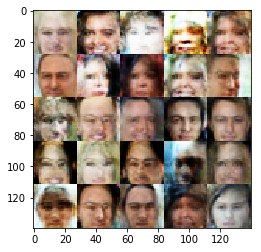

Epoch 2/2 Step 9220... Discriminator Loss: 1.1625... Generator Loss: 0.8677 ... Elapsed Time: 0:58:38.221095
Epoch 2/2 Step 9240... Discriminator Loss: 1.2962... Generator Loss: 0.4832 ... Elapsed Time: 0:58:45.748113
Epoch 2/2 Step 9260... Discriminator Loss: 1.1392... Generator Loss: 0.5362 ... Elapsed Time: 0:58:53.267111
Epoch 2/2 Step 9280... Discriminator Loss: 0.8509... Generator Loss: 1.3004 ... Elapsed Time: 0:59:00.926349
Epoch 2/2 Step 9300... Discriminator Loss: 1.3529... Generator Loss: 0.4711 ... Elapsed Time: 0:59:08.491471
Epoch 2/2 Step 9320... Discriminator Loss: 0.8954... Generator Loss: 0.9621 ... Elapsed Time: 0:59:16.040544
Epoch 2/2 Step 9340... Discriminator Loss: 0.9662... Generator Loss: 1.1127 ... Elapsed Time: 0:59:23.499603
Epoch 2/2 Step 9360... Discriminator Loss: 1.0451... Generator Loss: 0.8927 ... Elapsed Time: 0:59:31.015592
Epoch 2/2 Step 9380... Discriminator Loss: 1.8509... Generator Loss: 0.2254 ... Elapsed Time: 0:59:38.517553
Epoch 2/2 Step 9400

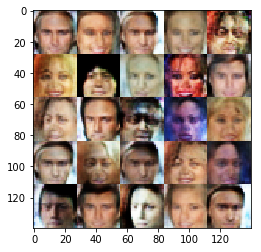

Epoch 2/2 Step 9420... Discriminator Loss: 1.0022... Generator Loss: 1.0440 ... Elapsed Time: 0:59:54.360719
Epoch 2/2 Step 9440... Discriminator Loss: 1.2114... Generator Loss: 0.8963 ... Elapsed Time: 1:00:01.872770
Epoch 2/2 Step 9460... Discriminator Loss: 0.9536... Generator Loss: 1.1095 ... Elapsed Time: 1:00:09.644498
Epoch 2/2 Step 9480... Discriminator Loss: 1.5490... Generator Loss: 0.4351 ... Elapsed Time: 1:00:17.190391
Epoch 2/2 Step 9500... Discriminator Loss: 1.0147... Generator Loss: 0.8233 ... Elapsed Time: 1:00:24.704983
Epoch 2/2 Step 9520... Discriminator Loss: 0.9713... Generator Loss: 0.7746 ... Elapsed Time: 1:00:32.215959
Epoch 2/2 Step 9540... Discriminator Loss: 2.2197... Generator Loss: 0.2988 ... Elapsed Time: 1:00:39.698860
Epoch 2/2 Step 9560... Discriminator Loss: 1.2390... Generator Loss: 0.9256 ... Elapsed Time: 1:00:47.295063
Epoch 2/2 Step 9580... Discriminator Loss: 1.3879... Generator Loss: 0.4296 ... Elapsed Time: 1:00:54.912808


In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.